# Autoencoder

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
%matplotlib notebook 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prep data

In [4]:
raw_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=float)

In [5]:
raw_data = torch.tensor(raw_data).float() # convert to float32

In [6]:
NN = 100
data = raw_data.T[:,:NN] # take first NN neurons for now
data.shape

torch.Size([226814, 100])

In [7]:
# split into training and validation data
np.random.seed(42)
split = int(0.8 * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
train_data = data[indices[:split]]
val_data = data[indices[split:]]

In [8]:
non_zero_train_data = train_data[train_data.sum(axis=1)!=0]

In [9]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
non_zero_train_data_loader = torch.utils.data.DataLoader(
    non_zero_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
zero_data_loader = torch.utils.data.DataLoader(torch.zeros((100,NN)), batch_size=BATCH_SIZE)

## Define model

In [11]:
def init_weights(layer,fill_bias=0):
    #torch.nn.init.constant_(layer.bias, fill_bias)
    torch.nn.init.orthogonal_(layer.weight,gain=np.sqrt(2))

In [12]:
class Encoder(nn.Module):
    def __init__(self, 
                 layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [160,10,2]"):
        super(Encoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1]) 
    
    def forward(self, x):
        for layer in self.layers[:-1]: # encode
            x = F.relu(layer(x))
        x =  self.layers[-1](x)
        return x

In [13]:
class Decoder(nn.Module):
    def __init__(self, 
                layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [2,4,160]"):
        super(Decoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1])
        
    def forward(self, z):
        for layer in self.layers[:-1]: # decode
            z = F.relu(layer(z))
        z = self.layers[-1](z) # don't apply activation on last layer
        z = torch.sigmoid(z) #squish
        return z

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, encoder_layer_dims, decoder_layer_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(encoder_layer_dims)
        self.decoder = Decoder(decoder_layer_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [15]:
ae = Autoencoder([NN,4,2],[2,4,NN])
batch = next(iter(train_data_loader))
reconstruction = ae(batch)
torch.round(reconstruction)

tensor([[1., 1., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.]], grad_fn=<RoundBackward0>)

## Define training loop

In [16]:
def man(x,x_hat):
    return ( torch.abs(x - x_hat) ).sum()

In [17]:
def eucl(x,x_hat):
    return ( (x - x_hat)**2 ).sum()

In [18]:
def hamming(x,x_hat):
    return ( x*(1-x_hat) + (1-x)*x_hat ).sum()

In [19]:
def train(autoencoder, data_loader, epochs=20, lr=.001, loss_fn=eucl):
    opt = torch.optim.AdamW(autoencoder.parameters(),lr)
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for epoch in range(epochs):
        epoch_loss = 0
        for x in tqdm(data_loader):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = loss_fn(x, x_hat)
            loss.backward()
            opt.step()
            
            epoch_loss += loss
            
        # calculate validation loss
        val_loss = loss_fn( val_data, autoencoder(val_data) )
        # normalise and take local values 
        mean_train_loss = epoch_loss.item() / train_data.shape[0]
        mean_val_loss = val_loss.item() / val_data.shape[0]
        # add to this models train and val loss trajectories
        train_losses[epoch] = mean_train_loss
        train_losses[epoch] = mean_val_loss
        print(f"{epoch}. Train loss: {np.round(mean_train_loss,2)}, Val loss: {np.round(mean_val_loss,2)}")
        
    return autoencoder, train_losses, val_losses

Define model

In [21]:
torch.manual_seed(0)
# define model
NNs = train_data.shape[1]
latent_dims = 2
encoder_layer_dims = [NNs,150,100,100,100,latent_dims]
decoder_layer_dims = encoder_layer_dims[::-1]
ae = Autoencoder(encoder_layer_dims, decoder_layer_dims).to(device) # GPU

We can choose between the following datasets:

- `train_data_loader` : which comprises a shuffled portion of the observed states
- `non_zero_train_data_loader` : which compresis a shuffled portion of the observed states where at least 1 neuron fired
- `zero_data_loader` : which is just a data-set of empty states

In [35]:
ae, train_loss, val_loss = train(ae, train_data_loader, 50,lr=.0001,loss_fn=eucl)

100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 343.53it/s]


0. Train loss: 2.08, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 250.97it/s]


1. Train loss: 2.08, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 338.99it/s]


2. Train loss: 2.08, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 220.06it/s]


3. Train loss: 2.08, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.26it/s]


4. Train loss: 2.07, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 376.51it/s]


5. Train loss: 2.07, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.09it/s]


6. Train loss: 2.07, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.62it/s]


7. Train loss: 2.07, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.34it/s]


8. Train loss: 2.07, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.95it/s]


9. Train loss: 2.07, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.74it/s]


10. Train loss: 2.06, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.93it/s]


11. Train loss: 2.07, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 396.32it/s]


12. Train loss: 2.06, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 397.43it/s]


13. Train loss: 2.06, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.03it/s]


14. Train loss: 2.06, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.97it/s]


15. Train loss: 2.06, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.31it/s]


16. Train loss: 2.06, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.69it/s]


17. Train loss: 2.06, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.44it/s]


18. Train loss: 2.06, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.16it/s]


19. Train loss: 2.05, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 381.80it/s]


20. Train loss: 2.05, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.19it/s]


21. Train loss: 2.05, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.50it/s]


22. Train loss: 2.05, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.90it/s]


23. Train loss: 2.05, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.04it/s]


24. Train loss: 2.05, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.86it/s]


25. Train loss: 2.05, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.75it/s]


26. Train loss: 2.05, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.01it/s]


27. Train loss: 2.05, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.29it/s]


28. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.45it/s]


29. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 366.22it/s]


30. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.00it/s]


31. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.83it/s]


32. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 377.61it/s]


33. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.45it/s]


34. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 388.71it/s]


35. Train loss: 2.04, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.12it/s]


36. Train loss: 2.04, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 294.55it/s]


37. Train loss: 2.04, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.38it/s]


38. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.79it/s]


39. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.66it/s]


40. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.94it/s]


41. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.93it/s]


42. Train loss: 2.03, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.67it/s]


43. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.88it/s]


44. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.66it/s]


45. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.84it/s]


46. Train loss: 2.03, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.07it/s]


47. Train loss: 2.03, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 333.89it/s]


48. Train loss: 2.03, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 386.37it/s]


49. Train loss: 2.02, Val loss: 2.1


## Visualise latent representations

In [36]:
def plot_latent(autoencoder, data):
    """
        Plots the latent representation of states, colouring states by how many neurons fire
        data should be a SxN tensor where S is the number of states and N the number of neurons
    """
    Ks = data.sum(axis=1).detach().numpy() #how many neurons fired in each state
    z = ae.encoder(data).detach().numpy() #SxL where L is the latent dimensions
    
    for i in range(z.shape[1]-1):
        for j in range(i+1,z.shape[1]):
            print(i,j)
            cmap = plt.get_cmap('RdBu', np.max(Ks)-np.min(Ks)+1)
            plt.scatter(z[:,i],z[:,j],c=Ks,marker=".",cmap=cmap)
            plt.colorbar()
            plt.show()

0 1


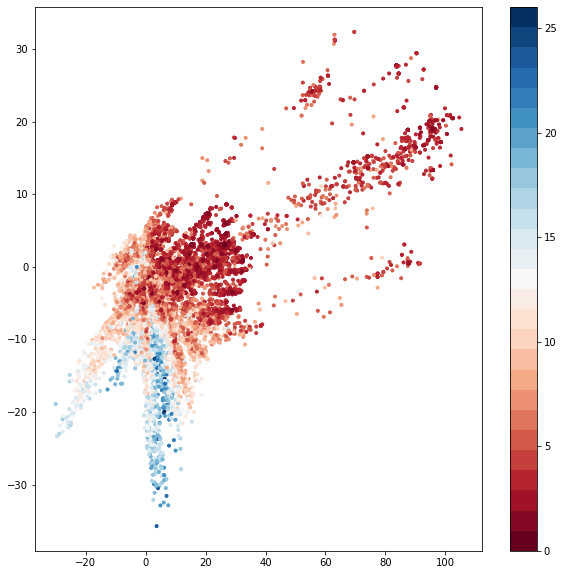

In [37]:
plt.figure(figsize=(10,10))
plot_latent(ae,val_data)
plt.show()

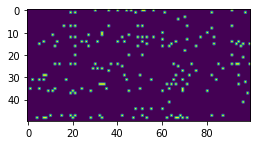

In [28]:
# how the actual data looks like
plt.figure(figsize=(4,10))
plt.imshow(val_data.unsqueeze(-1).numpy()[:50])

## Looking at the hamming distance on validation data

In [38]:
recon = ae(val_data)

In [39]:
Ks = val_data.sum(axis=1)

In [40]:
def hamming(data, recon):
    XORS = data * (1-recon) + (1-data) * recon
    return XORS.sum(1)

In [41]:
val_data.shape

torch.Size([45363, 100])

In [42]:
torch.zeros(val_data.shape)
torch.mean( eucl(val_data, torch.ones(val_data.shape) ) ).item()

4360633.0

In [43]:
print("Mean hamming distance: ", np.round(torch.mean(hamming(val_data, torch.round(ae(val_data)))).item(),3))

print("Hamming distances")
print("%2s %5s %4s %4s" % ("K", "obvs", "mean", "max"))

for K in range(int(torch.max(Ks))+1):
    states_K_fire = val_data[Ks==K]
    recon = torch.round(ae(states_K_fire))
    ham_dists = hamming(states_K_fire,recon)
    N_samples = states_K_fire.shape[0]
    print("%2s %5s %.2f %3s" % (K, N_samples, float(torch.mean(ham_dists)), int(torch.max(ham_dists)) ))
    

Mean hamming distance:  2.442
Hamming distances
 K  obvs mean  max
 0 12865 0.00   0
 1  6957 0.14   2
 2  4226 0.74   7
 3  3163 1.41   7
 4  2730 2.20  11
 5  2401 3.00  11
 6  2156 3.80  17
 7  1940 4.57  13
 8  1622 5.45  15
 9  1556 6.10  15
10  1272 6.97  15
11  1001 7.68  15
12   857 8.52  19
13   641 9.37  18
14   535 10.23  19
15   412 11.00  18
16   322 11.89  19
17   242 12.91  19
18   163 13.23  21
19   127 14.39  22
20    73 14.66  20
21    41 16.17  23
22    26 18.50  24
23    23 16.96  25
24     7 18.29  21
25     3 24.00  25
26     2 18.00  19


In [1]:
# if we are interested in comparing the data vs. 
states_K_fire = val_data[Ks==26]
recons = torch.round(ae(states_K_fire))
for state, recon in zip(states_K_fire, recons):
    print(state.numpy())
    print(recon.detach().numpy())
    print("----")

NameError: name 'val_data' is not defined

## Model selection
We now consider different model architectures, specifically, various sizes of bottlenecks and see how well 

In [46]:
np.random.seed(43)
torch.manual_seed(1)
NN = train_data.shape[1]
latent_dims = np.linspace(2,NN/2,4,dtype=int)
shapes = [] #save the combination of hyper-params here
train_losses = [] # save training losses
val_losses = [] #save the validation losses
iterations = 20

In [47]:
for latent_dim in latent_dims:
    print("Latent dimensions:", latent_dim, "=============")
    for i in range(iterations): # explore different architectures with the bottleneck
        
        # randomly define shape of encoder and decoder
        n_layers = np.random.randint(1,6)
        shape = [np.random.randint( latent_dim, int(NN*1.5) ) for _ in range(n_layers)]
        shape.sort(reverse=True)
        shape.insert(0,NN) #first layer input
        shape.append(latent_dim) #bottleneck output
        
        shapes.append(shape)

        # define model
        autoencoder = Autoencoder(shape, shape[::-1]).to(device) # GPU
        print("Model shape:", shape)
        
        # train until validation loss stops decreasing over 3 epochs
        min_loss=1e10
        incr_it=0 # keeps track whether validation loss has increased
        
        # add arrays to keep track of training and validation losses
        train_losses.append([])
        val_losses.append([])

        for epoch in range(100):
            opt = torch.optim.AdamW(autoencoder.parameters(),1e-3)
            epoch_loss = 0
            for x in tqdm(train_data_loader): # go through data training model 
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = eucl(x, x_hat) # use euclidean loss
                loss.backward()
                opt.step()

                epoch_loss += loss
                
            # calculate validation loss
            val_loss = eucl( val_data, autoencoder(val_data) )
            # normalise and take local values 
            mean_train_loss = epoch_loss.item() / train_data.shape[0]
            mean_val_loss = val_loss.item() / val_data.shape[0]
            # add to this models train and val loss trajectories
            train_losses[-1].append(mean_train_loss)
            val_losses[-1].append(mean_val_loss)
            print(f"{epoch}. Train loss: {np.round(train_losses[-1][-1],2)}, Val loss: {np.round(val_losses[-1][-1],2)}")
            
            # check val_loss is still decreasing
            if val_losses[-1][-1] < min_loss:
                min_loss = val_losses[-1][-1]
                incr_it = 0
                continue
            if incr_it == 2:
                break # train a new model with this many latent dims
            incr_it += 1

Latent dimensions: 2 =============
Model shape: [100, 66, 60, 51, 23, 18, 2]


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1053.73it/s]


0. Train loss: 2.91, Val loss: 2.59


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1065.89it/s]


1. Train loss: 2.51, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1060.27it/s]


2. Train loss: 2.44, Val loss: 2.43


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1065.72it/s]


3. Train loss: 2.4, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1051.99it/s]


4. Train loss: 2.38, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1027.40it/s]


5. Train loss: 2.35, Val loss: 2.35


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1040.39it/s]


6. Train loss: 2.35, Val loss: 2.38


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1067.37it/s]


7. Train loss: 2.34, Val loss: 2.35


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1026.51it/s]


8. Train loss: 2.31, Val loss: 2.34


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 982.63it/s]


9. Train loss: 2.3, Val loss: 2.32


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1028.91it/s]


10. Train loss: 2.28, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1042.97it/s]


11. Train loss: 2.27, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 999.27it/s]


12. Train loss: 2.31, Val loss: 2.28


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1034.57it/s]


13. Train loss: 2.29, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1070.34it/s]


14. Train loss: 2.29, Val loss: 2.32


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1068.35it/s]


15. Train loss: 2.28, Val loss: 2.29
Model shape: [100, 147, 112, 93, 89, 2]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.73it/s]


0. Train loss: 2.72, Val loss: 2.46


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.62it/s]


1. Train loss: 2.38, Val loss: 2.35


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.00it/s]


2. Train loss: 2.29, Val loss: 2.29


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.54it/s]


3. Train loss: 2.25, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.06it/s]


4. Train loss: 2.22, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.40it/s]


5. Train loss: 2.2, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.24it/s]


6. Train loss: 2.19, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.08it/s]


7. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.15it/s]


8. Train loss: 2.16, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.12it/s]


9. Train loss: 2.14, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.13it/s]


10. Train loss: 2.13, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.00it/s]


11. Train loss: 2.12, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.53it/s]


12. Train loss: 2.11, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 371.95it/s]


13. Train loss: 2.1, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.05it/s]


14. Train loss: 2.11, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.16it/s]


15. Train loss: 2.1, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 292.06it/s]


16. Train loss: 2.09, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.20it/s]


17. Train loss: 2.07, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 364.27it/s]


18. Train loss: 2.08, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.73it/s]


19. Train loss: 2.09, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 304.69it/s]


20. Train loss: 2.09, Val loss: 2.11
Model shape: [100, 37, 2]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2471.52it/s]


0. Train loss: 3.34, Val loss: 2.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2455.11it/s]


1. Train loss: 2.77, Val loss: 2.74


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2431.06it/s]


2. Train loss: 2.7, Val loss: 2.69


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2503.40it/s]


3. Train loss: 2.66, Val loss: 2.65


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2510.03it/s]


4. Train loss: 2.63, Val loss: 2.63


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2478.31it/s]


5. Train loss: 2.61, Val loss: 2.61


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2387.61it/s]


6. Train loss: 2.58, Val loss: 2.58


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2289.19it/s]


7. Train loss: 2.57, Val loss: 2.57


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2375.45it/s]


8. Train loss: 2.55, Val loss: 2.56


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2536.42it/s]


9. Train loss: 2.55, Val loss: 2.55


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2571.92it/s]


10. Train loss: 2.54, Val loss: 2.55


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2533.41it/s]


11. Train loss: 2.53, Val loss: 2.54


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2534.50it/s]


12. Train loss: 2.52, Val loss: 2.54


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2542.86it/s]


13. Train loss: 2.52, Val loss: 2.53


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2523.29it/s]


14. Train loss: 2.52, Val loss: 2.53


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2568.73it/s]


15. Train loss: 2.51, Val loss: 2.52


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2547.54it/s]


16. Train loss: 2.51, Val loss: 2.52


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2552.96it/s]


17. Train loss: 2.51, Val loss: 2.52


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2544.70it/s]


18. Train loss: 2.5, Val loss: 2.52


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2412.47it/s]


19. Train loss: 2.5, Val loss: 2.51


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2319.36it/s]


20. Train loss: 2.5, Val loss: 2.51


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2394.07it/s]


21. Train loss: 2.5, Val loss: 2.51


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2473.96it/s]


22. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2462.47it/s]


23. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2586.46it/s]


24. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2575.30it/s]


25. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2582.69it/s]


26. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2525.45it/s]


27. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2564.06it/s]


28. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2566.33it/s]


29. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2611.63it/s]


30. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2560.09it/s]


31. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2583.78it/s]


32. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2609.22it/s]


33. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2623.37it/s]


34. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2564.37it/s]


35. Train loss: 2.47, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2476.88it/s]


36. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2571.72it/s]


37. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2578.46it/s]


38. Train loss: 2.47, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2590.39it/s]


39. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2595.08it/s]


40. Train loss: 2.46, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2593.54it/s]


41. Train loss: 2.46, Val loss: 2.47


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2587.62it/s]


42. Train loss: 2.46, Val loss: 2.47


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2598.58it/s]


43. Train loss: 2.46, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2611.30it/s]


44. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2630.13it/s]


45. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2611.95it/s]


46. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2619.01it/s]


47. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2597.51it/s]


48. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2610.68it/s]


49. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2603.77it/s]


50. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2532.61it/s]


51. Train loss: 2.45, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2565.42it/s]


52. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2625.90it/s]


53. Train loss: 2.44, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2578.72it/s]


54. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2535.96it/s]


55. Train loss: 2.44, Val loss: 2.45
Model shape: [100, 125, 113, 91, 2]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.64it/s]


0. Train loss: 2.71, Val loss: 2.48


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 386.43it/s]


1. Train loss: 2.39, Val loss: 2.36


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 376.40it/s]


2. Train loss: 2.31, Val loss: 2.3


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.68it/s]


3. Train loss: 2.26, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.46it/s]


4. Train loss: 2.23, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.38it/s]


5. Train loss: 2.2, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.97it/s]


6. Train loss: 2.18, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.78it/s]


7. Train loss: 2.16, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 388.21it/s]


8. Train loss: 2.14, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.35it/s]


9. Train loss: 2.13, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.18it/s]


10. Train loss: 2.11, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.63it/s]


11. Train loss: 2.11, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 322.05it/s]


12. Train loss: 2.1, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.87it/s]


13. Train loss: 2.09, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.42it/s]


14. Train loss: 2.08, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.53it/s]


15. Train loss: 2.08, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 492.83it/s]


16. Train loss: 2.07, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 501.75it/s]


17. Train loss: 2.06, Val loss: 2.08


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.48it/s]


18. Train loss: 2.06, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.76it/s]


19. Train loss: 2.06, Val loss: 2.08


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.42it/s]


20. Train loss: 2.05, Val loss: 2.08


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 466.97it/s]


21. Train loss: 2.05, Val loss: 2.07


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 472.21it/s]


22. Train loss: 2.04, Val loss: 2.06


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.50it/s]


23. Train loss: 2.04, Val loss: 2.07


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 458.36it/s]


24. Train loss: 2.04, Val loss: 2.06


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.78it/s]


25. Train loss: 2.03, Val loss: 2.06


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 435.86it/s]


26. Train loss: 2.03, Val loss: 2.06


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 425.25it/s]


27. Train loss: 2.03, Val loss: 2.05


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.29it/s]


28. Train loss: 2.02, Val loss: 2.06


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.18it/s]


29. Train loss: 2.03, Val loss: 2.06


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.08it/s]


30. Train loss: 2.02, Val loss: 2.05


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.57it/s]


31. Train loss: 2.02, Val loss: 2.07


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.31it/s]


32. Train loss: 2.02, Val loss: 2.04


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.23it/s]


33. Train loss: 2.01, Val loss: 2.03


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 464.72it/s]


34. Train loss: 2.01, Val loss: 2.04


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.73it/s]


35. Train loss: 2.01, Val loss: 2.05


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 417.76it/s]


36. Train loss: 2.01, Val loss: 2.05
Model shape: [100, 134, 119, 77, 2]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 432.19it/s]


0. Train loss: 2.92, Val loss: 2.52


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.19it/s]


1. Train loss: 2.43, Val loss: 2.4


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 415.00it/s]


2. Train loss: 2.33, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 441.06it/s]


3. Train loss: 2.28, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.45it/s]


4. Train loss: 2.24, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.63it/s]


5. Train loss: 2.22, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 454.55it/s]


6. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.87it/s]


7. Train loss: 2.19, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.77it/s]


8. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 475.66it/s]


9. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.89it/s]


10. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.50it/s]


11. Train loss: 2.15, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 476.32it/s]


12. Train loss: 2.14, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 460.19it/s]


13. Train loss: 2.13, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.37it/s]


14. Train loss: 2.13, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.98it/s]


15. Train loss: 2.12, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.97it/s]


16. Train loss: 2.12, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 260.14it/s]


17. Train loss: 2.11, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 354.61it/s]


18. Train loss: 2.11, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.64it/s]


19. Train loss: 2.1, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 240.95it/s]


20. Train loss: 2.1, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 205.84it/s]


21. Train loss: 2.1, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.03it/s]


22. Train loss: 2.09, Val loss: 2.12
Model shape: [100, 119, 114, 75, 62, 34, 2]


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.08it/s]


0. Train loss: 2.83, Val loss: 2.48


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.77it/s]


1. Train loss: 2.41, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 250.87it/s]


2. Train loss: 2.34, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 395.36it/s]


3. Train loss: 2.29, Val loss: 2.31


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.50it/s]


4. Train loss: 2.26, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.08it/s]


5. Train loss: 2.23, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.10it/s]


6. Train loss: 2.21, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.98it/s]


7. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.22it/s]


8. Train loss: 2.18, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.69it/s]


9. Train loss: 2.18, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 343.42it/s]


10. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.55it/s]


11. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.48it/s]


12. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.68it/s]


13. Train loss: 2.18, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 281.43it/s]


14. Train loss: 2.18, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.71it/s]


15. Train loss: 2.16, Val loss: 2.18
Model shape: [100, 122, 50, 30, 2]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 551.49it/s]


0. Train loss: 2.85, Val loss: 2.54


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 677.77it/s]


1. Train loss: 2.46, Val loss: 2.43


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 684.03it/s]


2. Train loss: 2.36, Val loss: 2.34


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 581.48it/s]


3. Train loss: 2.3, Val loss: 2.3


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 591.61it/s]


4. Train loss: 2.27, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.12it/s]


5. Train loss: 2.24, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 610.06it/s]


6. Train loss: 2.22, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 750.55it/s]


7. Train loss: 2.21, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 637.18it/s]


8. Train loss: 2.19, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 551.68it/s]


9. Train loss: 2.18, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 630.81it/s]


10. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 712.96it/s]


11. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 803.03it/s]


12. Train loss: 2.16, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 798.30it/s]


13. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 807.23it/s]


14. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 831.72it/s]


15. Train loss: 2.14, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 804.21it/s]


16. Train loss: 2.13, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 807.83it/s]


17. Train loss: 2.13, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 762.60it/s]


18. Train loss: 2.12, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 788.35it/s]


19. Train loss: 2.12, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 770.03it/s]


20. Train loss: 2.12, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 711.21it/s]


21. Train loss: 2.11, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 761.03it/s]


22. Train loss: 2.11, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 773.63it/s]


23. Train loss: 2.11, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 804.41it/s]


24. Train loss: 2.1, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 432.43it/s]


25. Train loss: 2.1, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 835.48it/s]


26. Train loss: 2.1, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 813.80it/s]


27. Train loss: 2.1, Val loss: 2.11


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 798.95it/s]


28. Train loss: 2.09, Val loss: 2.12
Model shape: [100, 137, 63, 2]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 692.29it/s]


0. Train loss: 2.83, Val loss: 2.56


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 643.59it/s]


1. Train loss: 2.48, Val loss: 2.44


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 683.02it/s]


2. Train loss: 2.39, Val loss: 2.37


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 671.46it/s]


3. Train loss: 2.34, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 683.97it/s]


4. Train loss: 2.3, Val loss: 2.31


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 639.28it/s]


5. Train loss: 2.28, Val loss: 2.29


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 597.67it/s]


6. Train loss: 2.26, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 598.07it/s]


7. Train loss: 2.24, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 517.19it/s]


8. Train loss: 2.23, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 639.36it/s]


9. Train loss: 2.22, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 712.06it/s]


10. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 707.42it/s]


11. Train loss: 2.19, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 704.22it/s]


12. Train loss: 2.18, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 703.72it/s]


13. Train loss: 2.18, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 717.92it/s]


14. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 709.83it/s]


15. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 681.73it/s]


16. Train loss: 2.16, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 709.60it/s]


17. Train loss: 2.15, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 707.09it/s]


18. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 629.45it/s]


19. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 607.95it/s]


20. Train loss: 2.14, Val loss: 2.17
Model shape: [100, 120, 106, 49, 23, 5, 2]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.83it/s]


0. Train loss: 2.83, Val loss: 2.53


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.58it/s]


1. Train loss: 2.48, Val loss: 2.46


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 513.78it/s]


2. Train loss: 2.41, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 483.11it/s]


3. Train loss: 2.36, Val loss: 2.37


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.91it/s]


4. Train loss: 2.33, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.06it/s]


5. Train loss: 2.31, Val loss: 2.3


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.30it/s]


6. Train loss: 2.29, Val loss: 2.29


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.57it/s]


7. Train loss: 2.28, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.91it/s]


8. Train loss: 2.28, Val loss: 2.31


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 335.88it/s]


9. Train loss: 2.27, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 475.40it/s]


10. Train loss: 2.28, Val loss: 2.29


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.81it/s]


11. Train loss: 2.24, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.62it/s]


12. Train loss: 2.25, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.59it/s]


13. Train loss: 2.25, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 488.60it/s]


14. Train loss: 2.26, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.57it/s]


15. Train loss: 2.25, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.68it/s]


16. Train loss: 2.22, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 460.41it/s]


17. Train loss: 2.24, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.08it/s]


18. Train loss: 2.27, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.59it/s]


19. Train loss: 2.24, Val loss: 2.24
Model shape: [100, 76, 2]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2258.82it/s]


0. Train loss: 3.12, Val loss: 2.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2283.06it/s]


1. Train loss: 2.72, Val loss: 2.69


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2244.60it/s]


2. Train loss: 2.64, Val loss: 2.63


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2279.30it/s]


3. Train loss: 2.6, Val loss: 2.59


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2297.16it/s]


4. Train loss: 2.57, Val loss: 2.57


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2339.25it/s]


5. Train loss: 2.54, Val loss: 2.55


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2279.21it/s]


6. Train loss: 2.52, Val loss: 2.53


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2372.37it/s]


7. Train loss: 2.51, Val loss: 2.52


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2219.03it/s]


8. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2087.85it/s]


9. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2283.13it/s]


10. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2311.11it/s]


11. Train loss: 2.46, Val loss: 2.47


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2274.35it/s]


12. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2334.93it/s]


13. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2347.75it/s]


14. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2313.23it/s]


15. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2314.18it/s]


16. Train loss: 2.42, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2300.77it/s]


17. Train loss: 2.42, Val loss: 2.43


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2378.70it/s]


18. Train loss: 2.42, Val loss: 2.43


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2337.03it/s]


19. Train loss: 2.41, Val loss: 2.43


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2342.22it/s]


20. Train loss: 2.41, Val loss: 2.42


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2351.36it/s]


21. Train loss: 2.41, Val loss: 2.42


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2349.18it/s]


22. Train loss: 2.4, Val loss: 2.42


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2341.38it/s]


23. Train loss: 2.4, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2330.20it/s]


24. Train loss: 2.4, Val loss: 2.42


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2306.74it/s]


25. Train loss: 2.4, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2358.06it/s]


26. Train loss: 2.4, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2338.21it/s]


27. Train loss: 2.39, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2179.66it/s]


28. Train loss: 2.39, Val loss: 2.41
Model shape: [100, 120, 101, 63, 9, 2]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.49it/s]


0. Train loss: 2.92, Val loss: 2.54


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 497.37it/s]


1. Train loss: 2.42, Val loss: 2.39


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.79it/s]


2. Train loss: 2.33, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.61it/s]


3. Train loss: 2.28, Val loss: 2.3


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 302.13it/s]


4. Train loss: 2.25, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 534.27it/s]


5. Train loss: 2.22, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 433.36it/s]


6. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.13it/s]


7. Train loss: 2.19, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 457.25it/s]


8. Train loss: 2.18, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.31it/s]


9. Train loss: 2.16, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 522.16it/s]


10. Train loss: 2.14, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 548.91it/s]


11. Train loss: 2.14, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.35it/s]


12. Train loss: 2.13, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.78it/s]


13. Train loss: 2.13, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.60it/s]


14. Train loss: 2.12, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 510.16it/s]


15. Train loss: 2.12, Val loss: 2.14


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 364.79it/s]


16. Train loss: 2.11, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 520.61it/s]


17. Train loss: 2.1, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.89it/s]


18. Train loss: 2.1, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 533.87it/s]


19. Train loss: 2.11, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 523.39it/s]


20. Train loss: 2.1, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.73it/s]


21. Train loss: 2.09, Val loss: 2.13
Model shape: [100, 148, 108, 54, 25, 2]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.56it/s]


0. Train loss: 3.04, Val loss: 2.54


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.34it/s]


1. Train loss: 2.44, Val loss: 2.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 539.11it/s]


2. Train loss: 2.35, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 516.18it/s]


3. Train loss: 2.31, Val loss: 2.3


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 540.41it/s]


4. Train loss: 2.27, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 515.38it/s]


5. Train loss: 2.24, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 507.49it/s]


6. Train loss: 2.23, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 500.30it/s]


7. Train loss: 2.22, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.84it/s]


8. Train loss: 2.2, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.77it/s]


9. Train loss: 2.18, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 529.32it/s]


10. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 519.53it/s]


11. Train loss: 2.16, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.25it/s]


12. Train loss: 2.15, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 540.07it/s]


13. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 501.94it/s]


14. Train loss: 2.16, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.56it/s]


15. Train loss: 2.16, Val loss: 2.17
Model shape: [100, 125, 72, 53, 26, 2]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 577.51it/s]


0. Train loss: 2.92, Val loss: 2.53


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 528.45it/s]


1. Train loss: 2.46, Val loss: 2.42


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 545.53it/s]


2. Train loss: 2.37, Val loss: 2.35


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 525.22it/s]


3. Train loss: 2.32, Val loss: 2.31


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 519.39it/s]


4. Train loss: 2.28, Val loss: 2.29


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 548.23it/s]


5. Train loss: 2.26, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 577.27it/s]


6. Train loss: 2.24, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.51it/s]


7. Train loss: 2.22, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.10it/s]


8. Train loss: 2.21, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 540.17it/s]


9. Train loss: 2.2, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 515.11it/s]


10. Train loss: 2.19, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.29it/s]


11. Train loss: 2.18, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 512.03it/s]


12. Train loss: 2.17, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.92it/s]


13. Train loss: 2.16, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 540.03it/s]


14. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.03it/s]


15. Train loss: 2.15, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.50it/s]


16. Train loss: 2.14, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 545.61it/s]


17. Train loss: 2.14, Val loss: 2.15


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.59it/s]


18. Train loss: 2.14, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.11it/s]


19. Train loss: 2.13, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 524.14it/s]


20. Train loss: 2.12, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.26it/s]


21. Train loss: 2.12, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 581.76it/s]


22. Train loss: 2.11, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 366.99it/s]


23. Train loss: 2.11, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.83it/s]


24. Train loss: 2.11, Val loss: 2.15
Model shape: [100, 89, 87, 85, 38, 16, 2]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.91it/s]


0. Train loss: 2.93, Val loss: 2.57


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.98it/s]


1. Train loss: 2.53, Val loss: 2.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 633.57it/s]


2. Train loss: 2.45, Val loss: 2.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 629.15it/s]


3. Train loss: 2.4, Val loss: 2.39


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 647.42it/s]


4. Train loss: 2.38, Val loss: 2.37


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 627.82it/s]


5. Train loss: 2.34, Val loss: 2.35


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 648.74it/s]


6. Train loss: 2.31, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 631.47it/s]


7. Train loss: 2.3, Val loss: 2.34


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.57it/s]


8. Train loss: 2.28, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.44it/s]


9. Train loss: 2.28, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 482.24it/s]


10. Train loss: 2.26, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 588.32it/s]


11. Train loss: 2.24, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 591.85it/s]


12. Train loss: 2.24, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 534.98it/s]


13. Train loss: 2.24, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.77it/s]


14. Train loss: 2.35, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 595.63it/s]


15. Train loss: 2.3, Val loss: 2.32
Model shape: [100, 128, 44, 42, 29, 2]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 682.86it/s]


0. Train loss: 3.04, Val loss: 2.57


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 720.43it/s]


1. Train loss: 2.5, Val loss: 2.44


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 738.47it/s]


2. Train loss: 2.41, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 448.32it/s]


3. Train loss: 2.36, Val loss: 2.37


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 615.10it/s]


4. Train loss: 2.33, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 752.34it/s]


5. Train loss: 2.3, Val loss: 2.3


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 657.49it/s]


6. Train loss: 2.28, Val loss: 2.31


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 699.39it/s]


7. Train loss: 2.26, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 725.70it/s]


8. Train loss: 2.25, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 708.10it/s]


9. Train loss: 2.24, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 635.74it/s]


10. Train loss: 2.23, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 698.01it/s]


11. Train loss: 2.22, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 706.53it/s]


12. Train loss: 2.2, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 673.44it/s]


13. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 673.86it/s]


14. Train loss: 2.19, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.48it/s]


15. Train loss: 2.19, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 715.00it/s]


16. Train loss: 2.2, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 674.57it/s]


17. Train loss: 2.19, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 703.60it/s]


18. Train loss: 2.19, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 702.21it/s]


19. Train loss: 2.18, Val loss: 2.19
Model shape: [100, 146, 18, 2]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 810.00it/s]


0. Train loss: 2.92, Val loss: 2.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 840.09it/s]


1. Train loss: 2.53, Val loss: 2.48


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 853.24it/s]


2. Train loss: 2.44, Val loss: 2.43


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 888.07it/s]


3. Train loss: 2.39, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 871.86it/s]


4. Train loss: 2.35, Val loss: 2.36


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 834.71it/s]


5. Train loss: 2.32, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 831.52it/s]


6. Train loss: 2.3, Val loss: 2.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 831.95it/s]


7. Train loss: 2.28, Val loss: 2.29


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 833.01it/s]


8. Train loss: 2.27, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 834.25it/s]


9. Train loss: 2.25, Val loss: 2.27


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 867.23it/s]


10. Train loss: 2.24, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 876.56it/s]


11. Train loss: 2.23, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 823.11it/s]


12. Train loss: 2.22, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 828.20it/s]


13. Train loss: 2.22, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 802.80it/s]


14. Train loss: 2.21, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 845.28it/s]


15. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 856.06it/s]


16. Train loss: 2.2, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 802.84it/s]


17. Train loss: 2.19, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 799.03it/s]


18. Train loss: 2.19, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 853.27it/s]


19. Train loss: 2.18, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 819.46it/s]


20. Train loss: 2.18, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 829.26it/s]


21. Train loss: 2.17, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 818.48it/s]


22. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.91it/s]


23. Train loss: 2.17, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 857.48it/s]


24. Train loss: 2.16, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 818.90it/s]


25. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 641.45it/s]


26. Train loss: 2.16, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 880.03it/s]


27. Train loss: 2.16, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 849.90it/s]


28. Train loss: 2.15, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 810.13it/s]


29. Train loss: 2.15, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 818.50it/s]


30. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 719.78it/s]


31. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 829.22it/s]


32. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 880.58it/s]


33. Train loss: 2.15, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 778.53it/s]


34. Train loss: 2.14, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 902.38it/s]


35. Train loss: 2.14, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 873.90it/s]


36. Train loss: 2.14, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 859.51it/s]


37. Train loss: 2.14, Val loss: 2.17
Model shape: [100, 127, 65, 33, 15, 7, 2]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.61it/s]


0. Train loss: 3.4, Val loss: 2.66


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 505.25it/s]


1. Train loss: 2.56, Val loss: 2.5


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.29it/s]


2. Train loss: 2.45, Val loss: 2.44


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 464.69it/s]


3. Train loss: 2.39, Val loss: 2.39


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 539.66it/s]


4. Train loss: 2.35, Val loss: 2.34


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 506.98it/s]


5. Train loss: 2.32, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 529.44it/s]


6. Train loss: 2.29, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 498.95it/s]


7. Train loss: 2.26, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 503.43it/s]


8. Train loss: 2.24, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 502.71it/s]


9. Train loss: 2.23, Val loss: 2.24


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.26it/s]


10. Train loss: 2.22, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.73it/s]


11. Train loss: 2.21, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 498.39it/s]


12. Train loss: 2.2, Val loss: 2.24
Model shape: [100, 53, 2]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2361.50it/s]


0. Train loss: 3.27, Val loss: 2.85


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2377.93it/s]


1. Train loss: 2.78, Val loss: 2.75


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2380.19it/s]


2. Train loss: 2.71, Val loss: 2.69


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2342.24it/s]


3. Train loss: 2.65, Val loss: 2.63


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2368.12it/s]


4. Train loss: 2.6, Val loss: 2.59


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2405.36it/s]


5. Train loss: 2.57, Val loss: 2.57


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2431.27it/s]


6. Train loss: 2.54, Val loss: 2.54


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2387.37it/s]


7. Train loss: 2.53, Val loss: 2.53


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2408.85it/s]


8. Train loss: 2.52, Val loss: 2.52


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2429.90it/s]


9. Train loss: 2.51, Val loss: 2.51


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2400.42it/s]


10. Train loss: 2.5, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2409.96it/s]


11. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2392.77it/s]


12. Train loss: 2.49, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2427.79it/s]


13. Train loss: 2.48, Val loss: 2.5


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2456.48it/s]


14. Train loss: 2.48, Val loss: 2.49


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2283.14it/s]


15. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2223.32it/s]


16. Train loss: 2.46, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2228.51it/s]


17. Train loss: 2.46, Val loss: 2.47


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2370.25it/s]


18. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2427.85it/s]


19. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2413.08it/s]


20. Train loss: 2.45, Val loss: 2.46


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2410.00it/s]


21. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2458.52it/s]


22. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2421.17it/s]


23. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2350.58it/s]


24. Train loss: 2.44, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2223.79it/s]


25. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2193.34it/s]


26. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2222.65it/s]


27. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2358.43it/s]


28. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2418.03it/s]


29. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2407.09it/s]


30. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2418.88it/s]


31. Train loss: 2.43, Val loss: 2.44
Model shape: [100, 72, 6, 2]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1869.42it/s]


0. Train loss: 3.23, Val loss: 2.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1897.52it/s]


1. Train loss: 2.72, Val loss: 2.67


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1868.97it/s]


2. Train loss: 2.62, Val loss: 2.6


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1895.30it/s]


3. Train loss: 2.55, Val loss: 2.54


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1834.09it/s]


4. Train loss: 2.51, Val loss: 2.51


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1705.64it/s]


5. Train loss: 2.47, Val loss: 2.48


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1782.84it/s]


6. Train loss: 2.45, Val loss: 2.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1884.32it/s]


7. Train loss: 2.43, Val loss: 2.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1872.26it/s]


8. Train loss: 2.42, Val loss: 2.43


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1925.95it/s]


9. Train loss: 2.41, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1862.97it/s]


10. Train loss: 2.4, Val loss: 2.41


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1927.42it/s]


11. Train loss: 2.39, Val loss: 2.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1885.16it/s]


12. Train loss: 2.38, Val loss: 2.39


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1883.82it/s]


13. Train loss: 2.38, Val loss: 2.39


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1899.24it/s]


14. Train loss: 2.37, Val loss: 2.39


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1914.99it/s]


15. Train loss: 2.37, Val loss: 2.38


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1887.17it/s]


16. Train loss: 2.36, Val loss: 2.37


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1916.69it/s]


17. Train loss: 2.36, Val loss: 2.37


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1927.71it/s]


18. Train loss: 2.35, Val loss: 2.37


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1916.95it/s]


19. Train loss: 2.35, Val loss: 2.36


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1916.89it/s]


20. Train loss: 2.34, Val loss: 2.36


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1891.37it/s]


21. Train loss: 2.34, Val loss: 2.36


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1921.00it/s]


22. Train loss: 2.34, Val loss: 2.35


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1902.13it/s]


23. Train loss: 2.33, Val loss: 2.34


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1717.63it/s]


24. Train loss: 2.33, Val loss: 2.34


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1749.13it/s]


25. Train loss: 2.33, Val loss: 2.34


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1901.96it/s]


26. Train loss: 2.32, Val loss: 2.34


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1872.01it/s]


27. Train loss: 2.32, Val loss: 2.34


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1893.18it/s]


28. Train loss: 2.32, Val loss: 2.33


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1870.74it/s]


29. Train loss: 2.31, Val loss: 2.34


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1860.92it/s]


30. Train loss: 2.31, Val loss: 2.32


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1895.84it/s]


31. Train loss: 2.31, Val loss: 2.33


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1855.60it/s]


32. Train loss: 2.31, Val loss: 2.32


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1879.10it/s]


33. Train loss: 2.31, Val loss: 2.32


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1860.30it/s]


34. Train loss: 2.3, Val loss: 2.32


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1904.25it/s]


35. Train loss: 2.3, Val loss: 2.31


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1861.02it/s]


36. Train loss: 2.3, Val loss: 2.31


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1891.46it/s]


37. Train loss: 2.29, Val loss: 2.31


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1900.14it/s]


38. Train loss: 2.29, Val loss: 2.31


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1880.13it/s]


39. Train loss: 2.29, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1915.34it/s]


40. Train loss: 2.29, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1880.78it/s]


41. Train loss: 2.28, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1889.09it/s]


42. Train loss: 2.28, Val loss: 2.29


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1904.89it/s]


43. Train loss: 2.28, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1890.58it/s]


44. Train loss: 2.28, Val loss: 2.3


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1921.51it/s]


45. Train loss: 2.28, Val loss: 2.29


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1881.35it/s]


46. Train loss: 2.27, Val loss: 2.29


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1735.21it/s]


47. Train loss: 2.27, Val loss: 2.29


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1897.65it/s]


48. Train loss: 2.27, Val loss: 2.29


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1940.38it/s]


49. Train loss: 2.27, Val loss: 2.28


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1864.41it/s]


50. Train loss: 2.27, Val loss: 2.28


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1884.19it/s]


51. Train loss: 2.27, Val loss: 2.29


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1883.63it/s]


52. Train loss: 2.27, Val loss: 2.28


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1742.20it/s]


53. Train loss: 2.27, Val loss: 2.28


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1732.42it/s]


54. Train loss: 2.26, Val loss: 2.28


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1864.18it/s]


55. Train loss: 2.26, Val loss: 2.28
Model shape: [100, 93, 89, 87, 27, 26, 2]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 477.52it/s]


0. Train loss: 2.79, Val loss: 2.58


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 457.97it/s]


1. Train loss: 2.42, Val loss: 2.36


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 479.05it/s]


2. Train loss: 2.33, Val loss: 2.33


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 455.50it/s]


3. Train loss: 2.28, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.58it/s]


4. Train loss: 2.25, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.57it/s]


5. Train loss: 2.23, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 291.04it/s]


6. Train loss: 2.21, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 498.55it/s]


7. Train loss: 2.19, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.31it/s]


8. Train loss: 2.18, Val loss: 2.22


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 472.01it/s]


9. Train loss: 2.18, Val loss: 2.24
Latent dimensions: 18 =============
Model shape: [100, 141, 43, 41, 18]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 748.63it/s]


0. Train loss: 1.69, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 781.84it/s]


1. Train loss: 0.96, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 755.33it/s]


2. Train loss: 0.83, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 717.83it/s]


3. Train loss: 0.77, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 667.16it/s]


4. Train loss: 0.73, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 725.65it/s]


5. Train loss: 0.71, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 735.97it/s]


6. Train loss: 0.69, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 722.11it/s]


7. Train loss: 0.67, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 678.16it/s]


8. Train loss: 0.66, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 708.26it/s]


9. Train loss: 0.65, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 673.53it/s]


10. Train loss: 0.64, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 723.51it/s]


11. Train loss: 0.63, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.44it/s]


12. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 780.00it/s]


13. Train loss: 0.61, Val loss: 0.65
Model shape: [100, 126, 18]


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 964.80it/s]


0. Train loss: 1.76, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 484.53it/s]


1. Train loss: 0.86, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 974.95it/s]


2. Train loss: 0.76, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 896.90it/s]


3. Train loss: 0.71, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 880.72it/s]


4. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 737.25it/s]


5. Train loss: 0.65, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 889.45it/s]


6. Train loss: 0.63, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 910.47it/s]


7. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 898.41it/s]


8. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 922.79it/s]


9. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 859.22it/s]


10. Train loss: 0.57, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 881.39it/s]


11. Train loss: 0.56, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 938.18it/s]


12. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 878.63it/s]


13. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 888.81it/s]


14. Train loss: 0.53, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 888.82it/s]


15. Train loss: 0.52, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 869.71it/s]


16. Train loss: 0.51, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 889.28it/s]


17. Train loss: 0.5, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 847.44it/s]


18. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 906.42it/s]


19. Train loss: 0.49, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 650.18it/s]


20. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 899.32it/s]


21. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 871.41it/s]


22. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 826.02it/s]


23. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 917.06it/s]


24. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 864.70it/s]


25. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 920.94it/s]


26. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 900.76it/s]


27. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.81it/s]


28. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 909.67it/s]


29. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 891.25it/s]


30. Train loss: 0.4, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 901.83it/s]


31. Train loss: 0.39, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 900.58it/s]


32. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 864.99it/s]


33. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 759.98it/s]


34. Train loss: 0.36, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 932.52it/s]


35. Train loss: 0.35, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 925.57it/s]


36. Train loss: 0.35, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 967.53it/s]


37. Train loss: 0.34, Val loss: 0.36


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1035.06it/s]


38. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 778.87it/s]


39. Train loss: 0.33, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1024.25it/s]


40. Train loss: 0.32, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.29it/s]


41. Train loss: 0.32, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1031.85it/s]


42. Train loss: 0.32, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 993.32it/s]


43. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 978.38it/s]


44. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 997.08it/s]


45. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.11it/s]


46. Train loss: 0.31, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1012.50it/s]


47. Train loss: 0.3, Val loss: 0.32


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1002.22it/s]


48. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 994.09it/s]


49. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.96it/s]


50. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 986.90it/s]


51. Train loss: 0.3, Val loss: 0.32
Model shape: [100, 124, 104, 69, 60, 42, 18]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.96it/s]


0. Train loss: 2.82, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.94it/s]


1. Train loss: 1.66, Val loss: 1.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.49it/s]


2. Train loss: 1.45, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.39it/s]


3. Train loss: 1.32, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.19it/s]


4. Train loss: 1.24, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.24it/s]


5. Train loss: 1.17, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.72it/s]


6. Train loss: 1.13, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 426.56it/s]


7. Train loss: 1.1, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.53it/s]


8. Train loss: 1.08, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 335.36it/s]


9. Train loss: 1.06, Val loss: 1.14
Model shape: [100, 117, 99, 68, 18]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.85it/s]


0. Train loss: 1.66, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 255.37it/s]


1. Train loss: 0.96, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 542.67it/s]


2. Train loss: 0.87, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.41it/s]


3. Train loss: 0.81, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 533.98it/s]


4. Train loss: 0.75, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 554.70it/s]


5. Train loss: 0.72, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 565.34it/s]


6. Train loss: 0.7, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 543.70it/s]


7. Train loss: 0.68, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 537.80it/s]


8. Train loss: 0.66, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.60it/s]


9. Train loss: 0.65, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 469.20it/s]


10. Train loss: 0.64, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 501.79it/s]


11. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 535.16it/s]


12. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 533.63it/s]


13. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.27it/s]


14. Train loss: 0.6, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 532.00it/s]


15. Train loss: 0.59, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.35it/s]


16. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.52it/s]


17. Train loss: 0.57, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 522.25it/s]


18. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.99it/s]


19. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 502.04it/s]


20. Train loss: 0.54, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 512.37it/s]


21. Train loss: 0.53, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 526.58it/s]


22. Train loss: 0.52, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.01it/s]


23. Train loss: 0.51, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 384.90it/s]


24. Train loss: 0.5, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 548.86it/s]


25. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.91it/s]


26. Train loss: 0.49, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.53it/s]


27. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 552.94it/s]


28. Train loss: 0.47, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.66it/s]


29. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 560.97it/s]


30. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 511.77it/s]


31. Train loss: 0.45, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 565.41it/s]


32. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 553.24it/s]


33. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.59it/s]


34. Train loss: 0.43, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 554.03it/s]


35. Train loss: 0.43, Val loss: 0.47
Model shape: [100, 132, 113, 51, 18]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 545.73it/s]


0. Train loss: 2.1, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 552.73it/s]


1. Train loss: 0.98, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 512.09it/s]


2. Train loss: 0.87, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 424.06it/s]


3. Train loss: 0.79, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 543.92it/s]


4. Train loss: 0.75, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.60it/s]


5. Train loss: 0.72, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 515.17it/s]


6. Train loss: 0.7, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.76it/s]


7. Train loss: 0.68, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 534.76it/s]


8. Train loss: 0.66, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.48it/s]


9. Train loss: 0.65, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.72it/s]


10. Train loss: 0.64, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 537.92it/s]


11. Train loss: 0.63, Val loss: 0.67
Model shape: [100, 117, 38, 34, 23, 18]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 699.63it/s]


0. Train loss: 2.44, Val loss: 1.63


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 708.65it/s]


1. Train loss: 1.46, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 703.33it/s]


2. Train loss: 1.28, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 597.30it/s]


3. Train loss: 1.21, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 653.08it/s]


4. Train loss: 1.17, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 681.56it/s]


5. Train loss: 1.14, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.65it/s]


6. Train loss: 1.11, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 671.88it/s]


7. Train loss: 1.08, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.16it/s]


8. Train loss: 1.05, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 677.22it/s]


9. Train loss: 1.02, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.78it/s]


10. Train loss: 1.0, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 663.05it/s]


11. Train loss: 0.99, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 698.09it/s]


12. Train loss: 0.98, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 692.37it/s]


13. Train loss: 0.97, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 673.24it/s]


14. Train loss: 0.95, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 649.16it/s]


15. Train loss: 0.94, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.27it/s]


16. Train loss: 0.94, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 675.48it/s]


17. Train loss: 0.93, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 624.00it/s]


18. Train loss: 0.92, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 653.20it/s]


19. Train loss: 0.91, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 690.23it/s]


20. Train loss: 0.91, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 664.06it/s]


21. Train loss: 0.9, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 648.40it/s]


22. Train loss: 0.9, Val loss: 0.93
Model shape: [100, 129, 62, 41, 18]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 732.79it/s]


0. Train loss: 3.25, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 709.16it/s]


1. Train loss: 1.13, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 642.73it/s]


2. Train loss: 0.88, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 674.21it/s]


3. Train loss: 0.79, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.70it/s]


4. Train loss: 0.74, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 707.81it/s]


5. Train loss: 0.71, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 677.73it/s]


6. Train loss: 0.69, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 557.90it/s]


7. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 711.98it/s]


8. Train loss: 0.65, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 584.06it/s]


9. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 662.49it/s]


10. Train loss: 0.63, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 712.27it/s]


11. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.18it/s]


12. Train loss: 0.61, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 726.88it/s]


13. Train loss: 0.59, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 713.31it/s]


14. Train loss: 0.58, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 700.18it/s]


15. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.13it/s]


16. Train loss: 0.56, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.13it/s]


17. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 777.76it/s]


18. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 687.58it/s]


19. Train loss: 0.54, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 454.18it/s]


20. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 699.24it/s]


21. Train loss: 0.52, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 720.16it/s]


22. Train loss: 0.51, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.81it/s]


23. Train loss: 0.51, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 697.90it/s]


24. Train loss: 0.5, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 689.64it/s]


25. Train loss: 0.49, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 435.98it/s]


26. Train loss: 0.49, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 565.20it/s]


27. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 670.61it/s]


28. Train loss: 0.47, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.84it/s]


29. Train loss: 0.46, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 673.94it/s]


30. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 691.38it/s]


31. Train loss: 0.45, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.82it/s]


32. Train loss: 0.45, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 714.26it/s]


33. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 680.71it/s]


34. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 634.08it/s]


35. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 733.10it/s]


36. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 704.07it/s]


37. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 686.01it/s]


38. Train loss: 0.41, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 624.08it/s]


39. Train loss: 0.4, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 613.19it/s]


40. Train loss: 0.4, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 650.30it/s]


41. Train loss: 0.39, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.12it/s]


42. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 679.47it/s]


43. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 761.67it/s]


44. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 694.41it/s]


45. Train loss: 0.37, Val loss: 0.4
Model shape: [100, 97, 61, 18]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 837.70it/s]


0. Train loss: 2.03, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 818.59it/s]


1. Train loss: 0.95, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 794.86it/s]


2. Train loss: 0.83, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.98it/s]


3. Train loss: 0.76, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.11it/s]


4. Train loss: 0.72, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 816.26it/s]


5. Train loss: 0.69, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 883.96it/s]


6. Train loss: 0.67, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 833.58it/s]


7. Train loss: 0.65, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 850.32it/s]


8. Train loss: 0.64, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 793.42it/s]


9. Train loss: 0.62, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 881.22it/s]


10. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 804.99it/s]


11. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 816.22it/s]


12. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 828.58it/s]


13. Train loss: 0.59, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 878.87it/s]


14. Train loss: 0.58, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 841.95it/s]


15. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 829.66it/s]


16. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 845.11it/s]


17. Train loss: 0.56, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 820.54it/s]


18. Train loss: 0.56, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 778.70it/s]


19. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 696.50it/s]


20. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 893.64it/s]


21. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 809.35it/s]


22. Train loss: 0.53, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 831.53it/s]


23. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 492.41it/s]


24. Train loss: 0.52, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.50it/s]


25. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 815.78it/s]


26. Train loss: 0.51, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 875.25it/s]


27. Train loss: 0.5, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 492.72it/s]


28. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 829.79it/s]


29. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 848.45it/s]


30. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 866.52it/s]


31. Train loss: 0.48, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 448.59it/s]


32. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 832.60it/s]


33. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 768.90it/s]


34. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 481.34it/s]


35. Train loss: 0.45, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 828.39it/s]


36. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 840.57it/s]


37. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 809.03it/s]


38. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 837.69it/s]


39. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 898.41it/s]


40. Train loss: 0.41, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 820.91it/s]


41. Train loss: 0.4, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 874.23it/s]


42. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 504.95it/s]


43. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 850.67it/s]


44. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 833.77it/s]


45. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 804.29it/s]


46. Train loss: 0.36, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.73it/s]


47. Train loss: 0.36, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 797.36it/s]


48. Train loss: 0.35, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 848.20it/s]


49. Train loss: 0.35, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.58it/s]


50. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 871.96it/s]


51. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 817.19it/s]


52. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 815.27it/s]


53. Train loss: 0.33, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 694.13it/s]


54. Train loss: 0.33, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 836.43it/s]


55. Train loss: 0.32, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 827.31it/s]


56. Train loss: 0.32, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 878.04it/s]


57. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 836.61it/s]


58. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 837.17it/s]


59. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 813.65it/s]


60. Train loss: 0.31, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 837.82it/s]


61. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 524.85it/s]


62. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 794.70it/s]


63. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 832.77it/s]


64. Train loss: 0.3, Val loss: 0.33
Model shape: [100, 149, 64, 18]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.42it/s]


0. Train loss: 1.94, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.56it/s]


1. Train loss: 0.88, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 584.08it/s]


2. Train loss: 0.77, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.68it/s]


3. Train loss: 0.71, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 661.81it/s]


4. Train loss: 0.68, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.04it/s]


5. Train loss: 0.66, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 504.53it/s]


6. Train loss: 0.64, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 604.13it/s]


7. Train loss: 0.62, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 571.54it/s]


8. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.16it/s]


9. Train loss: 0.59, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 657.86it/s]


10. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 537.93it/s]


11. Train loss: 0.57, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 595.26it/s]


12. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 610.12it/s]


13. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 600.98it/s]


14. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.86it/s]


15. Train loss: 0.54, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 581.08it/s]


16. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 383.99it/s]


17. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 603.94it/s]


18. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.73it/s]


19. Train loss: 0.52, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 396.09it/s]


20. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.94it/s]


21. Train loss: 0.5, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 587.21it/s]


22. Train loss: 0.5, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 579.79it/s]


23. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 627.47it/s]


24. Train loss: 0.48, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 617.11it/s]


25. Train loss: 0.48, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 618.98it/s]


26. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 575.18it/s]


27. Train loss: 0.47, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 596.28it/s]


28. Train loss: 0.46, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 601.55it/s]


29. Train loss: 0.46, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 635.76it/s]


30. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 633.91it/s]


31. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.59it/s]


32. Train loss: 0.43, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 594.23it/s]


33. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 506.96it/s]


34. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.16it/s]


35. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 601.67it/s]


36. Train loss: 0.4, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 619.91it/s]


37. Train loss: 0.39, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 662.11it/s]


38. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 602.25it/s]


39. Train loss: 0.37, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 656.64it/s]


40. Train loss: 0.36, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.05it/s]


41. Train loss: 0.35, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 619.71it/s]


42. Train loss: 0.34, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 606.80it/s]


43. Train loss: 0.33, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 661.10it/s]


44. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 608.02it/s]


45. Train loss: 0.32, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 557.00it/s]


46. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 660.99it/s]


47. Train loss: 0.31, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 605.10it/s]


48. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 605.97it/s]


49. Train loss: 0.29, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 587.41it/s]


50. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 608.50it/s]


51. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 601.75it/s]


52. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.13it/s]


53. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 620.32it/s]


54. Train loss: 0.27, Val loss: 0.3
Model shape: [100, 135, 124, 40, 18]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.12it/s]


0. Train loss: 2.78, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 502.18it/s]


1. Train loss: 1.01, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 513.67it/s]


2. Train loss: 0.86, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 469.79it/s]


3. Train loss: 0.79, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.26it/s]


4. Train loss: 0.74, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 494.55it/s]


5. Train loss: 0.71, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.64it/s]


6. Train loss: 0.69, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 520.25it/s]


7. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.20it/s]


8. Train loss: 0.65, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 529.61it/s]


9. Train loss: 0.64, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 477.80it/s]


10. Train loss: 0.63, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.46it/s]


11. Train loss: 0.61, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.53it/s]


12. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.61it/s]


13. Train loss: 0.6, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 483.05it/s]


14. Train loss: 0.59, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.29it/s]


15. Train loss: 0.58, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.52it/s]


16. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.53it/s]


17. Train loss: 0.56, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 477.65it/s]


18. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 479.85it/s]


19. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 347.79it/s]


20. Train loss: 0.53, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.03it/s]


21. Train loss: 0.52, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 447.82it/s]


22. Train loss: 0.51, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.74it/s]


23. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 475.13it/s]


24. Train loss: 0.49, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.81it/s]


25. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 495.11it/s]


26. Train loss: 0.47, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.20it/s]


27. Train loss: 0.47, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.19it/s]


28. Train loss: 0.46, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 304.97it/s]


29. Train loss: 0.45, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 440.90it/s]


30. Train loss: 0.44, Val loss: 0.51
Model shape: [100, 95, 30, 18]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 717.33it/s]


0. Train loss: 1.79, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 826.56it/s]


1. Train loss: 0.99, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 862.83it/s]


2. Train loss: 0.88, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 832.66it/s]


3. Train loss: 0.81, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 717.34it/s]


4. Train loss: 0.77, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 860.66it/s]


5. Train loss: 0.74, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 801.04it/s]


6. Train loss: 0.72, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 838.76it/s]


7. Train loss: 0.7, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 895.50it/s]


8. Train loss: 0.69, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 832.24it/s]


9. Train loss: 0.68, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 829.61it/s]


10. Train loss: 0.67, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 816.02it/s]


11. Train loss: 0.66, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 582.26it/s]


12. Train loss: 0.65, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 727.20it/s]


13. Train loss: 0.65, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 829.67it/s]


14. Train loss: 0.64, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.24it/s]


15. Train loss: 0.63, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 703.70it/s]


16. Train loss: 0.63, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 866.69it/s]


17. Train loss: 0.62, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 864.53it/s]


18. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 897.50it/s]


19. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 855.38it/s]


20. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 525.50it/s]


21. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 659.47it/s]


22. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 849.98it/s]


23. Train loss: 0.59, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.31it/s]


24. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 916.48it/s]


25. Train loss: 0.57, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 889.91it/s]


26. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 894.02it/s]


27. Train loss: 0.56, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 912.51it/s]


28. Train loss: 0.56, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 867.64it/s]


29. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 866.89it/s]


30. Train loss: 0.55, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 897.52it/s]


31. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 568.59it/s]


32. Train loss: 0.54, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 710.22it/s]


33. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 859.97it/s]


34. Train loss: 0.53, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 827.33it/s]


35. Train loss: 0.53, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.33it/s]


36. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 674.52it/s]


37. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 841.19it/s]


38. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 753.72it/s]


39. Train loss: 0.51, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 851.79it/s]


40. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 897.12it/s]


41. Train loss: 0.5, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.14it/s]


42. Train loss: 0.49, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 907.13it/s]


43. Train loss: 0.49, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 514.29it/s]


44. Train loss: 0.48, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 920.84it/s]


45. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 923.24it/s]


46. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 889.01it/s]


47. Train loss: 0.47, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 743.63it/s]


48. Train loss: 0.47, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 929.88it/s]


49. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 828.22it/s]


50. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 839.16it/s]


51. Train loss: 0.46, Val loss: 0.48
Model shape: [100, 140, 18]


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 981.75it/s]


0. Train loss: 1.69, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 872.21it/s]


1. Train loss: 0.83, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 984.97it/s]


2. Train loss: 0.73, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 955.62it/s]


3. Train loss: 0.68, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 943.48it/s]


4. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 957.06it/s]


5. Train loss: 0.62, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 924.18it/s]


6. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 943.54it/s]


7. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 934.40it/s]


8. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 981.34it/s]


9. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 944.25it/s]


10. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 533.14it/s]


11. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 951.86it/s]


12. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 936.05it/s]


13. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 826.48it/s]


14. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 546.55it/s]


15. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 938.89it/s]


16. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 944.36it/s]


17. Train loss: 0.5, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 904.49it/s]


18. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.73it/s]


19. Train loss: 0.48, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 941.41it/s]


20. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 914.02it/s]


21. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 925.57it/s]


22. Train loss: 0.45, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 932.40it/s]


23. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 946.41it/s]


24. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 887.32it/s]


25. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 934.53it/s]


26. Train loss: 0.41, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 935.94it/s]


27. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.04it/s]


28. Train loss: 0.4, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 967.26it/s]


29. Train loss: 0.39, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 916.75it/s]


30. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.28it/s]


31. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 975.39it/s]


32. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 972.19it/s]


33. Train loss: 0.36, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 924.44it/s]


34. Train loss: 0.36, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 936.00it/s]


35. Train loss: 0.35, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 950.29it/s]


36. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 972.64it/s]


37. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 997.13it/s]


38. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 954.23it/s]


39. Train loss: 0.33, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 952.26it/s]


40. Train loss: 0.33, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 999.27it/s]


41. Train loss: 0.32, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 959.75it/s]


42. Train loss: 0.32, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 933.33it/s]


43. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 961.93it/s]


44. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 985.49it/s]


45. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 964.99it/s]


46. Train loss: 0.3, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 919.77it/s]


47. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 979.01it/s]


48. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 941.29it/s]


49. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.88it/s]


50. Train loss: 0.29, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 983.78it/s]


51. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 901.49it/s]


52. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 981.99it/s]


53. Train loss: 0.28, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 960.38it/s]


54. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 542.73it/s]


55. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 957.80it/s]


56. Train loss: 0.28, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 927.32it/s]


57. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 962.91it/s]


58. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 537.54it/s]


59. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 942.39it/s]


60. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 942.19it/s]


61. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 949.33it/s]


62. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 966.80it/s]


63. Train loss: 0.27, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 948.39it/s]


64. Train loss: 0.27, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 931.29it/s]


65. Train loss: 0.26, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 956.79it/s]


66. Train loss: 0.26, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 835.57it/s]


67. Train loss: 0.26, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.99it/s]


68. Train loss: 0.26, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 956.67it/s]


69. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 788.75it/s]


70. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 961.06it/s]


71. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.97it/s]


72. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 990.31it/s]


73. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 901.38it/s]


74. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 947.79it/s]


75. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 706.72it/s]


76. Train loss: 0.24, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 971.02it/s]


77. Train loss: 0.24, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 968.93it/s]


78. Train loss: 0.24, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 973.64it/s]


79. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 914.99it/s]


80. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 967.09it/s]


81. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 912.61it/s]


82. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 925.74it/s]


83. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 993.45it/s]


84. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 816.05it/s]


85. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 966.44it/s]


86. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.83it/s]


87. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 823.79it/s]


88. Train loss: 0.23, Val loss: 0.26
Model shape: [100, 103, 18]


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1027.40it/s]


0. Train loss: 1.92, Val loss: 1.0


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1054.47it/s]


1. Train loss: 0.9, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1035.63it/s]


2. Train loss: 0.8, Val loss: 0.78


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1024.30it/s]


3. Train loss: 0.74, Val loss: 0.73


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1059.23it/s]


4. Train loss: 0.7, Val loss: 0.7


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1022.99it/s]


5. Train loss: 0.67, Val loss: 0.68


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1021.86it/s]


6. Train loss: 0.65, Val loss: 0.66


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1069.33it/s]


7. Train loss: 0.63, Val loss: 0.65


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1044.07it/s]


8. Train loss: 0.62, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 989.49it/s]


9. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 560.20it/s]


10. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 725.60it/s]


11. Train loss: 0.59, Val loss: 0.62


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1030.30it/s]


12. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 904.90it/s]


13. Train loss: 0.58, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 783.14it/s]


14. Train loss: 0.57, Val loss: 0.6


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1021.00it/s]


15. Train loss: 0.56, Val loss: 0.59


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1008.27it/s]


16. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 992.02it/s]


17. Train loss: 0.55, Val loss: 0.57


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1064.15it/s]


18. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 968.53it/s]


19. Train loss: 0.53, Val loss: 0.56


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1068.46it/s]


20. Train loss: 0.53, Val loss: 0.55


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1054.38it/s]


21. Train loss: 0.52, Val loss: 0.55


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1012.92it/s]


22. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 984.97it/s]


23. Train loss: 0.51, Val loss: 0.54


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1020.81it/s]


24. Train loss: 0.5, Val loss: 0.53


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1044.23it/s]


25. Train loss: 0.5, Val loss: 0.52


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1053.12it/s]


26. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 927.80it/s]


27. Train loss: 0.48, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 955.60it/s]


28. Train loss: 0.48, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 907.91it/s]


29. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 496.70it/s]


30. Train loss: 0.47, Val loss: 0.49


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1032.21it/s]


31. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 992.29it/s]


32. Train loss: 0.46, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.82it/s]


33. Train loss: 0.45, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1083.07it/s]


34. Train loss: 0.45, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1009.13it/s]


35. Train loss: 0.44, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1050.60it/s]


36. Train loss: 0.44, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1014.39it/s]


37. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.74it/s]


38. Train loss: 0.43, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1075.09it/s]


39. Train loss: 0.42, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1039.87it/s]


40. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 681.29it/s]


41. Train loss: 0.41, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1066.21it/s]


42. Train loss: 0.41, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1080.50it/s]


43. Train loss: 0.4, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1052.87it/s]


44. Train loss: 0.4, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1017.80it/s]


45. Train loss: 0.4, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1047.24it/s]


46. Train loss: 0.39, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1083.16it/s]


47. Train loss: 0.39, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1013.97it/s]


48. Train loss: 0.39, Val loss: 0.41


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1056.95it/s]


49. Train loss: 0.39, Val loss: 0.41


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1032.34it/s]


50. Train loss: 0.38, Val loss: 0.41


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1025.21it/s]


51. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 885.11it/s]


52. Train loss: 0.38, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1041.66it/s]


53. Train loss: 0.37, Val loss: 0.39


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1037.58it/s]


54. Train loss: 0.37, Val loss: 0.39


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1010.16it/s]


55. Train loss: 0.36, Val loss: 0.39


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1003.27it/s]


56. Train loss: 0.36, Val loss: 0.39


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1034.96it/s]


57. Train loss: 0.36, Val loss: 0.38


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1026.79it/s]


58. Train loss: 0.35, Val loss: 0.38


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1061.61it/s]


59. Train loss: 0.35, Val loss: 0.37


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1039.92it/s]


60. Train loss: 0.35, Val loss: 0.37


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1043.27it/s]


61. Train loss: 0.34, Val loss: 0.36


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1046.72it/s]


62. Train loss: 0.34, Val loss: 0.36


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1047.11it/s]


63. Train loss: 0.33, Val loss: 0.36


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1045.42it/s]


64. Train loss: 0.33, Val loss: 0.36


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1039.01it/s]


65. Train loss: 0.33, Val loss: 0.35


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1028.80it/s]


66. Train loss: 0.32, Val loss: 0.35


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1007.62it/s]


67. Train loss: 0.32, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1004.81it/s]


68. Train loss: 0.32, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1047.28it/s]


69. Train loss: 0.32, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1047.02it/s]


70. Train loss: 0.32, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1019.85it/s]


71. Train loss: 0.31, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1014.28it/s]


72. Train loss: 0.31, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1008.90it/s]


73. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 879.85it/s]


74. Train loss: 0.31, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1054.97it/s]


75. Train loss: 0.31, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1039.17it/s]


76. Train loss: 0.31, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1018.98it/s]


77. Train loss: 0.3, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1042.69it/s]


78. Train loss: 0.3, Val loss: 0.33


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1029.42it/s]


79. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 796.57it/s]


80. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 824.73it/s]


81. Train loss: 0.3, Val loss: 0.32


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1060.28it/s]


82. Train loss: 0.3, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 973.91it/s]


83. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 904.49it/s]


84. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 858.12it/s]


85. Train loss: 0.29, Val loss: 0.31
Model shape: [100, 24, 18]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2423.87it/s]


0. Train loss: 2.14, Val loss: 1.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2476.28it/s]


1. Train loss: 1.1, Val loss: 1.08


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2481.99it/s]


2. Train loss: 1.04, Val loss: 1.05


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2461.18it/s]


3. Train loss: 1.02, Val loss: 1.04


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2497.73it/s]


4. Train loss: 1.01, Val loss: 1.04


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2475.29it/s]


5. Train loss: 1.0, Val loss: 1.01


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2513.45it/s]


6. Train loss: 0.99, Val loss: 1.0


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2478.84it/s]


7. Train loss: 0.98, Val loss: 0.99


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2539.84it/s]


8. Train loss: 0.97, Val loss: 0.99


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2473.32it/s]


9. Train loss: 0.96, Val loss: 0.98


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2495.99it/s]


10. Train loss: 0.95, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2527.09it/s]


11. Train loss: 0.94, Val loss: 0.96


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2525.40it/s]


12. Train loss: 0.94, Val loss: 0.96


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2502.87it/s]


13. Train loss: 0.93, Val loss: 0.95


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2517.70it/s]


14. Train loss: 0.92, Val loss: 0.93


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2545.31it/s]


15. Train loss: 0.92, Val loss: 0.94


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2515.16it/s]


16. Train loss: 0.91, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2504.36it/s]


17. Train loss: 0.9, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2517.52it/s]


18. Train loss: 0.89, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2524.41it/s]


19. Train loss: 0.88, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2404.46it/s]


20. Train loss: 0.87, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2520.48it/s]


21. Train loss: 0.86, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2532.52it/s]


22. Train loss: 0.86, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2498.41it/s]


23. Train loss: 0.85, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2530.30it/s]


24. Train loss: 0.85, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2568.64it/s]


25. Train loss: 0.84, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2547.04it/s]


26. Train loss: 0.84, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2554.96it/s]


27. Train loss: 0.84, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2550.65it/s]


28. Train loss: 0.83, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2421.53it/s]


29. Train loss: 0.83, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2491.82it/s]


30. Train loss: 0.83, Val loss: 0.85
Model shape: [100, 127, 18]


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 969.33it/s]


0. Train loss: 1.51, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 815.72it/s]


1. Train loss: 0.85, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 978.26it/s]


2. Train loss: 0.76, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 935.02it/s]


3. Train loss: 0.7, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 898.68it/s]


4. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 937.71it/s]


5. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 914.97it/s]


6. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 914.24it/s]


7. Train loss: 0.61, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 949.05it/s]


8. Train loss: 0.6, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 952.95it/s]


9. Train loss: 0.58, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 955.51it/s]


10. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 913.89it/s]


11. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 957.64it/s]


12. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 944.65it/s]


13. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 930.57it/s]


14. Train loss: 0.55, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 680.42it/s]


15. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 930.18it/s]


16. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 930.76it/s]


17. Train loss: 0.53, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 905.67it/s]


18. Train loss: 0.52, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 953.45it/s]


19. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 868.12it/s]


20. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 948.69it/s]


21. Train loss: 0.5, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 960.12it/s]


22. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 941.73it/s]


23. Train loss: 0.48, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 926.89it/s]


24. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 884.37it/s]


25. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 916.01it/s]


26. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 948.46it/s]


27. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 941.49it/s]


28. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 901.64it/s]


29. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 908.71it/s]


30. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 694.38it/s]


31. Train loss: 0.41, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 924.06it/s]


32. Train loss: 0.41, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 907.83it/s]


33. Train loss: 0.4, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 754.36it/s]


34. Train loss: 0.4, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 932.97it/s]


35. Train loss: 0.39, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 912.13it/s]


36. Train loss: 0.39, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 925.65it/s]


37. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 911.85it/s]


38. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 913.95it/s]


39. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 909.09it/s]


40. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 910.30it/s]


41. Train loss: 0.36, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 850.40it/s]


42. Train loss: 0.36, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 938.76it/s]


43. Train loss: 0.35, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 942.52it/s]


44. Train loss: 0.35, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 920.14it/s]


45. Train loss: 0.34, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 902.39it/s]


46. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 940.13it/s]


47. Train loss: 0.33, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 907.55it/s]


48. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 965.65it/s]


49. Train loss: 0.33, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 906.06it/s]


50. Train loss: 0.32, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 954.63it/s]


51. Train loss: 0.32, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 926.11it/s]


52. Train loss: 0.32, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 779.50it/s]


53. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 942.92it/s]


54. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 961.03it/s]


55. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 891.35it/s]


56. Train loss: 0.3, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 945.43it/s]


57. Train loss: 0.3, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 867.71it/s]


58. Train loss: 0.3, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 948.50it/s]


59. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 662.87it/s]


60. Train loss: 0.29, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 950.99it/s]


61. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 903.19it/s]


62. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 910.34it/s]


63. Train loss: 0.28, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 911.19it/s]


64. Train loss: 0.28, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 926.07it/s]


65. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 967.65it/s]


66. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 935.84it/s]


67. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 950.29it/s]


68. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 930.82it/s]


69. Train loss: 0.27, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 919.57it/s]


70. Train loss: 0.26, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.85it/s]


71. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 881.97it/s]


72. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 961.84it/s]


73. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 917.00it/s]


74. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 910.26it/s]


75. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 898.57it/s]


76. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 651.37it/s]


77. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 838.39it/s]


78. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 950.46it/s]


79. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 933.57it/s]


80. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 769.90it/s]


81. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 949.51it/s]


82. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 965.82it/s]


83. Train loss: 0.23, Val loss: 0.25


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1000.15it/s]


84. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 994.66it/s]


85. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 957.75it/s]


86. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 980.29it/s]


87. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 978.18it/s]


88. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 957.64it/s]


89. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 808.02it/s]


90. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 909.87it/s]


91. Train loss: 0.21, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 965.98it/s]


92. Train loss: 0.21, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 951.17it/s]


93. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 991.01it/s]


94. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 959.31it/s]


95. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 928.73it/s]


96. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 974.21it/s]


97. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 945.11it/s]


98. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 961.03it/s]


99. Train loss: 0.21, Val loss: 0.23
Model shape: [100, 147, 134, 61, 18]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 478.95it/s]


0. Train loss: 2.8, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.27it/s]


1. Train loss: 1.04, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.14it/s]


2. Train loss: 0.88, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.92it/s]


3. Train loss: 0.8, Val loss: 0.84


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 479.47it/s]


4. Train loss: 0.75, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.38it/s]


5. Train loss: 0.72, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 496.95it/s]


6. Train loss: 0.7, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 502.52it/s]


7. Train loss: 0.67, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.93it/s]


8. Train loss: 0.66, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 481.98it/s]


9. Train loss: 0.64, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.65it/s]


10. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 484.63it/s]


11. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 486.29it/s]


12. Train loss: 0.61, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.78it/s]


13. Train loss: 0.6, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.68it/s]


14. Train loss: 0.59, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 424.23it/s]


15. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 503.12it/s]


16. Train loss: 0.57, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 460.01it/s]


17. Train loss: 0.56, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 488.81it/s]


18. Train loss: 0.55, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 498.97it/s]


19. Train loss: 0.55, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 469.82it/s]


20. Train loss: 0.54, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 486.89it/s]


21. Train loss: 0.53, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 496.60it/s]


22. Train loss: 0.53, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 492.23it/s]


23. Train loss: 0.52, Val loss: 0.57
Model shape: [100, 145, 24, 18]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.94it/s]


0. Train loss: 1.8, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 723.48it/s]


1. Train loss: 0.9, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.10it/s]


2. Train loss: 0.8, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 815.49it/s]


3. Train loss: 0.74, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 797.79it/s]


4. Train loss: 0.71, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 807.38it/s]


5. Train loss: 0.68, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 738.54it/s]


6. Train loss: 0.66, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 791.01it/s]


7. Train loss: 0.65, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.26it/s]


8. Train loss: 0.63, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 801.10it/s]


9. Train loss: 0.62, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 789.34it/s]


10. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 817.98it/s]


11. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 793.59it/s]


12. Train loss: 0.6, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 820.29it/s]


13. Train loss: 0.59, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 737.39it/s]


14. Train loss: 0.58, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 794.35it/s]


15. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 813.98it/s]


16. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 802.82it/s]


17. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 629.05it/s]


18. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 819.94it/s]


19. Train loss: 0.55, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 784.47it/s]


20. Train loss: 0.54, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 815.21it/s]


21. Train loss: 0.54, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 724.57it/s]


22. Train loss: 0.53, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 604.07it/s]


23. Train loss: 0.53, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 766.54it/s]


24. Train loss: 0.52, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 805.61it/s]


25. Train loss: 0.52, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 777.32it/s]


26. Train loss: 0.51, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 776.86it/s]


27. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 775.56it/s]


28. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 817.15it/s]


29. Train loss: 0.49, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 810.68it/s]


30. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 795.21it/s]


31. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 826.48it/s]


32. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 771.84it/s]


33. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 668.36it/s]


34. Train loss: 0.46, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 806.84it/s]


35. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 804.69it/s]


36. Train loss: 0.45, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 786.96it/s]


37. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.52it/s]


38. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.90it/s]


39. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 805.53it/s]


40. Train loss: 0.43, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 809.32it/s]


41. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 797.73it/s]


42. Train loss: 0.42, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 781.84it/s]


43. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 807.63it/s]


44. Train loss: 0.41, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 822.32it/s]


45. Train loss: 0.4, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 791.73it/s]


46. Train loss: 0.39, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 793.73it/s]


47. Train loss: 0.39, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.41it/s]


48. Train loss: 0.39, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 779.44it/s]


49. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 656.32it/s]


50. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 818.43it/s]


51. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 764.55it/s]


52. Train loss: 0.37, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.29it/s]


53. Train loss: 0.37, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 683.32it/s]


54. Train loss: 0.37, Val loss: 0.4
Model shape: [100, 125, 98, 46, 37, 18]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.84it/s]


0. Train loss: 2.06, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.32it/s]


1. Train loss: 1.14, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 438.05it/s]


2. Train loss: 1.0, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.04it/s]


3. Train loss: 0.89, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 458.77it/s]


4. Train loss: 0.82, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 433.25it/s]


5. Train loss: 0.77, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.88it/s]


6. Train loss: 0.74, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 428.41it/s]


7. Train loss: 0.72, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.74it/s]


8. Train loss: 0.7, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.68it/s]


9. Train loss: 0.69, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 476.68it/s]


10. Train loss: 0.67, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 464.48it/s]


11. Train loss: 0.66, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 447.30it/s]


12. Train loss: 0.65, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.69it/s]


13. Train loss: 0.64, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.42it/s]


14. Train loss: 0.63, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.15it/s]


15. Train loss: 0.63, Val loss: 0.66
Model shape: [100, 116, 78, 68, 49, 18]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.10it/s]


0. Train loss: 2.86, Val loss: 1.57


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 425.91it/s]


1. Train loss: 1.32, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 440.85it/s]


2. Train loss: 1.09, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 448.59it/s]


3. Train loss: 0.99, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 415.05it/s]


4. Train loss: 0.91, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.09it/s]


5. Train loss: 0.86, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.40it/s]


6. Train loss: 0.82, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.84it/s]


7. Train loss: 0.79, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.80it/s]


8. Train loss: 0.77, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 433.16it/s]


9. Train loss: 0.75, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.32it/s]


10. Train loss: 0.73, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.69it/s]


11. Train loss: 0.71, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.19it/s]


12. Train loss: 0.69, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.67it/s]


13. Train loss: 0.68, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.73it/s]


14. Train loss: 0.67, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.31it/s]


15. Train loss: 0.65, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.27it/s]


16. Train loss: 0.65, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 409.54it/s]


17. Train loss: 0.64, Val loss: 0.67
Model shape: [100, 88, 57, 27, 18]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 790.34it/s]


0. Train loss: 2.46, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 713.83it/s]


1. Train loss: 1.12, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 772.49it/s]


2. Train loss: 0.95, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 755.33it/s]


3. Train loss: 0.84, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 759.29it/s]


4. Train loss: 0.78, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 730.79it/s]


5. Train loss: 0.75, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 734.26it/s]


6. Train loss: 0.73, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 737.59it/s]


7. Train loss: 0.71, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 740.32it/s]


8. Train loss: 0.69, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 742.87it/s]


9. Train loss: 0.68, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 782.38it/s]


10. Train loss: 0.67, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 651.65it/s]


11. Train loss: 0.66, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 760.26it/s]


12. Train loss: 0.65, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 707.12it/s]


13. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 626.37it/s]


14. Train loss: 0.63, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 735.31it/s]


15. Train loss: 0.62, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 715.25it/s]


16. Train loss: 0.62, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 673.08it/s]


17. Train loss: 0.61, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 684.22it/s]


18. Train loss: 0.6, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 753.81it/s]


19. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 693.83it/s]


20. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 685.83it/s]


21. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 645.17it/s]


22. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 760.18it/s]


23. Train loss: 0.57, Val loss: 0.61
Latent dimensions: 34 =============
Model shape: [100, 70, 34]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1994.50it/s]


0. Train loss: 1.39, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1971.81it/s]


1. Train loss: 0.37, Val loss: 0.35


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2007.98it/s]


2. Train loss: 0.31, Val loss: 0.3


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2002.99it/s]


3. Train loss: 0.28, Val loss: 0.28


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2005.94it/s]


4. Train loss: 0.26, Val loss: 0.26


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1917.54it/s]


5. Train loss: 0.24, Val loss: 0.24


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1983.73it/s]


6. Train loss: 0.23, Val loss: 0.24


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1838.57it/s]


7. Train loss: 0.22, Val loss: 0.23


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1772.70it/s]


8. Train loss: 0.2, Val loss: 0.21


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2036.78it/s]


9. Train loss: 0.2, Val loss: 0.21


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2017.46it/s]


10. Train loss: 0.19, Val loss: 0.2


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2019.71it/s]


11. Train loss: 0.19, Val loss: 0.2


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2049.82it/s]


12. Train loss: 0.18, Val loss: 0.21


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2042.49it/s]


13. Train loss: 0.18, Val loss: 0.19


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1937.98it/s]


14. Train loss: 0.17, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1921.74it/s]


15. Train loss: 0.17, Val loss: 0.19


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2018.27it/s]


16. Train loss: 0.17, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2037.61it/s]


17. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2042.99it/s]


18. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2075.50it/s]


19. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2005.11it/s]


20. Train loss: 0.15, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2065.56it/s]


21. Train loss: 0.15, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2059.22it/s]


22. Train loss: 0.15, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2076.14it/s]


23. Train loss: 0.15, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2056.76it/s]


24. Train loss: 0.15, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2033.09it/s]


25. Train loss: 0.14, Val loss: 0.16
Model shape: [100, 141, 130, 118, 62, 56, 34]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.52it/s]


0. Train loss: 3.9, Val loss: 3.87


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 322.15it/s]


1. Train loss: 2.15, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.48it/s]


2. Train loss: 1.6, Val loss: 1.51


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 335.14it/s]


3. Train loss: 1.45, Val loss: 1.46


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.75it/s]


4. Train loss: 1.36, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.42it/s]


5. Train loss: 1.28, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.33it/s]


6. Train loss: 1.22, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.77it/s]


7. Train loss: 1.19, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 371.96it/s]


8. Train loss: 1.16, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.77it/s]


9. Train loss: 1.13, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.30it/s]


10. Train loss: 1.1, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.15it/s]


11. Train loss: 1.08, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.03it/s]


12. Train loss: 1.06, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.02it/s]


13. Train loss: 1.03, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.88it/s]


14. Train loss: 1.02, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.84it/s]


15. Train loss: 1.01, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.78it/s]


16. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.66it/s]


17. Train loss: 0.99, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.12it/s]


18. Train loss: 0.98, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.97it/s]


19. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.34it/s]


20. Train loss: 0.96, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.65it/s]


21. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 354.10it/s]


22. Train loss: 0.95, Val loss: 1.0
Model shape: [100, 121, 109, 90, 40, 34]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.17it/s]


0. Train loss: 2.11, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.74it/s]


1. Train loss: 0.95, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.13it/s]


2. Train loss: 0.75, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.34it/s]


3. Train loss: 0.67, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.67it/s]


4. Train loss: 0.63, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.03it/s]


5. Train loss: 0.58, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 354.93it/s]


6. Train loss: 0.55, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.98it/s]


7. Train loss: 0.53, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.18it/s]


8. Train loss: 0.51, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.05it/s]


9. Train loss: 0.48, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.72it/s]


10. Train loss: 0.46, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.48it/s]


11. Train loss: 0.45, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 363.56it/s]


12. Train loss: 0.44, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.61it/s]


13. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.47it/s]


14. Train loss: 0.42, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.39it/s]


15. Train loss: 0.41, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 347.48it/s]


16. Train loss: 0.4, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.58it/s]


17. Train loss: 0.4, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.14it/s]


18. Train loss: 0.39, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.25it/s]


19. Train loss: 0.39, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 347.21it/s]


20. Train loss: 0.38, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.41it/s]


21. Train loss: 0.38, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.16it/s]


22. Train loss: 0.38, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.36it/s]


23. Train loss: 0.37, Val loss: 0.41
Model shape: [100, 134, 48, 34]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 665.63it/s]


0. Train loss: 1.85, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 782.79it/s]


1. Train loss: 0.5, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 760.05it/s]


2. Train loss: 0.41, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 550.57it/s]


3. Train loss: 0.35, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 781.22it/s]


4. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 751.12it/s]


5. Train loss: 0.29, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.03it/s]


6. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 691.00it/s]


7. Train loss: 0.24, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 639.12it/s]


8. Train loss: 0.23, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 809.06it/s]


9. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 603.28it/s]


10. Train loss: 0.22, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 807.62it/s]


11. Train loss: 0.21, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 765.42it/s]


12. Train loss: 0.19, Val loss: 0.23
Model shape: [100, 129, 92, 34]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 539.87it/s]


0. Train loss: 1.5, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.59it/s]


1. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.34it/s]


2. Train loss: 0.46, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 475.25it/s]


3. Train loss: 0.45, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 578.04it/s]


4. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 532.24it/s]


5. Train loss: 0.42, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 264.12it/s]


6. Train loss: 0.38, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 576.25it/s]


7. Train loss: 0.37, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 494.24it/s]


8. Train loss: 0.36, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 556.13it/s]


9. Train loss: 0.35, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 603.65it/s]


10. Train loss: 0.34, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.74it/s]


11. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.11it/s]


12. Train loss: 0.32, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 488.30it/s]


13. Train loss: 0.32, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.66it/s]


14. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 582.95it/s]


15. Train loss: 0.31, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.90it/s]


16. Train loss: 0.3, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 548.29it/s]


17. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 550.84it/s]


18. Train loss: 0.27, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 473.06it/s]


19. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 583.88it/s]


20. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 543.86it/s]


21. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 572.94it/s]


22. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.86it/s]


23. Train loss: 0.21, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 476.99it/s]


24. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.08it/s]


25. Train loss: 0.2, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 547.03it/s]


26. Train loss: 0.2, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 539.71it/s]


27. Train loss: 0.19, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 606.40it/s]


28. Train loss: 0.19, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 601.13it/s]


29. Train loss: 0.19, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 599.11it/s]


30. Train loss: 0.18, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 600.10it/s]


31. Train loss: 0.18, Val loss: 0.18


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.65it/s]


32. Train loss: 0.18, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 587.98it/s]


33. Train loss: 0.18, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 468.45it/s]


34. Train loss: 0.17, Val loss: 0.18


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.08it/s]


35. Train loss: 0.17, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 507.50it/s]


36. Train loss: 0.17, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.19it/s]


37. Train loss: 0.16, Val loss: 0.16


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 583.24it/s]


38. Train loss: 0.15, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 590.70it/s]


39. Train loss: 0.15, Val loss: 0.16


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.11it/s]


40. Train loss: 0.15, Val loss: 0.17
Model shape: [100, 66, 34]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1946.36it/s]


0. Train loss: 1.31, Val loss: 0.41


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1997.96it/s]


1. Train loss: 0.36, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2033.29it/s]


2. Train loss: 0.31, Val loss: 0.31


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1981.99it/s]


3. Train loss: 0.27, Val loss: 0.28


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2021.96it/s]


4. Train loss: 0.25, Val loss: 0.26


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2047.71it/s]


5. Train loss: 0.23, Val loss: 0.25


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2004.11it/s]


6. Train loss: 0.22, Val loss: 0.24


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2038.46it/s]


7. Train loss: 0.21, Val loss: 0.23


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2042.28it/s]


8. Train loss: 0.2, Val loss: 0.21


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2054.27it/s]


9. Train loss: 0.19, Val loss: 0.2


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2038.44it/s]


10. Train loss: 0.19, Val loss: 0.2


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2069.53it/s]


11. Train loss: 0.18, Val loss: 0.2


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2059.41it/s]


12. Train loss: 0.18, Val loss: 0.19


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2068.65it/s]


13. Train loss: 0.18, Val loss: 0.19


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2051.15it/s]


14. Train loss: 0.17, Val loss: 0.19


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2044.28it/s]


15. Train loss: 0.17, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2041.76it/s]


16. Train loss: 0.17, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2072.25it/s]


17. Train loss: 0.17, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2045.67it/s]


18. Train loss: 0.16, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2102.13it/s]


19. Train loss: 0.16, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2087.13it/s]


20. Train loss: 0.16, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2053.94it/s]


21. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2047.12it/s]


22. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2066.04it/s]


23. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2071.77it/s]


24. Train loss: 0.16, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2088.81it/s]


25. Train loss: 0.15, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1976.39it/s]


26. Train loss: 0.15, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1987.17it/s]


27. Train loss: 0.15, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1964.08it/s]


28. Train loss: 0.15, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2049.13it/s]


29. Train loss: 0.15, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2046.84it/s]


30. Train loss: 0.14, Val loss: 0.17
Model shape: [100, 100, 88, 73, 34]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 532.95it/s]


0. Train loss: 1.84, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 535.02it/s]


1. Train loss: 0.68, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.50it/s]


2. Train loss: 0.59, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.88it/s]


3. Train loss: 0.55, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.46it/s]


4. Train loss: 0.52, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 545.09it/s]


5. Train loss: 0.49, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 515.41it/s]


6. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.45it/s]


7. Train loss: 0.43, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 523.58it/s]


8. Train loss: 0.42, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 460.55it/s]


9. Train loss: 0.4, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 504.07it/s]


10. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.35it/s]


11. Train loss: 0.39, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 514.98it/s]


12. Train loss: 0.38, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 512.27it/s]


13. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.11it/s]


14. Train loss: 0.37, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 482.84it/s]


15. Train loss: 0.36, Val loss: 0.41
Model shape: [100, 146, 142, 92, 61, 48, 34]


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.76it/s]


0. Train loss: 3.25, Val loss: 2.02


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.60it/s]


1. Train loss: 1.8, Val loss: 1.68


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.26it/s]


2. Train loss: 1.57, Val loss: 1.5


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 276.44it/s]


3. Train loss: 1.42, Val loss: 1.39


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.41it/s]


4. Train loss: 1.32, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.48it/s]


5. Train loss: 1.26, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.03it/s]


6. Train loss: 1.21, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 277.24it/s]


7. Train loss: 1.18, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.35it/s]


8. Train loss: 1.15, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.42it/s]


9. Train loss: 1.12, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.01it/s]


10. Train loss: 1.11, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.94it/s]


11. Train loss: 1.09, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.26it/s]


12. Train loss: 1.07, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.66it/s]


13. Train loss: 1.06, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 283.78it/s]


14. Train loss: 1.04, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.11it/s]


15. Train loss: 1.03, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 243.22it/s]


16. Train loss: 1.01, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 322.87it/s]


17. Train loss: 1.0, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.55it/s]


18. Train loss: 0.98, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.37it/s]


19. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.34it/s]


20. Train loss: 0.96, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.46it/s]


21. Train loss: 0.95, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.83it/s]


22. Train loss: 0.94, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.11it/s]


23. Train loss: 0.93, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.02it/s]


24. Train loss: 0.92, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 276.10it/s]


25. Train loss: 0.92, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.30it/s]


26. Train loss: 0.91, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.47it/s]


27. Train loss: 0.91, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.09it/s]


28. Train loss: 0.9, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 304.77it/s]


29. Train loss: 0.89, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.38it/s]


30. Train loss: 0.89, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.30it/s]


31. Train loss: 0.88, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [7:06:28<00:00,  4.51s/it]


32. Train loss: 0.87, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.77it/s]


33. Train loss: 0.87, Val loss: 0.89
Model shape: [100, 42, 34, 34]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1475.66it/s]


0. Train loss: 1.66, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1565.47it/s]


1. Train loss: 0.85, Val loss: 0.78


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1592.02it/s]


2. Train loss: 0.71, Val loss: 0.69


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1445.67it/s]


3. Train loss: 0.65, Val loss: 0.65


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1498.22it/s]


4. Train loss: 0.62, Val loss: 0.61


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1406.52it/s]


5. Train loss: 0.59, Val loss: 0.57


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1486.51it/s]


6. Train loss: 0.53, Val loss: 0.53


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1481.30it/s]


7. Train loss: 0.5, Val loss: 0.5


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1318.30it/s]


8. Train loss: 0.48, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1374.05it/s]


9. Train loss: 0.47, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1346.64it/s]


10. Train loss: 0.46, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1316.81it/s]


11. Train loss: 0.45, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1253.98it/s]


12. Train loss: 0.45, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1052.99it/s]


13. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 840.59it/s]


14. Train loss: 0.44, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1146.47it/s]


15. Train loss: 0.43, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1303.46it/s]


16. Train loss: 0.43, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1432.24it/s]


17. Train loss: 0.42, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1438.95it/s]


18. Train loss: 0.42, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1412.82it/s]


19. Train loss: 0.41, Val loss: 0.41


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1431.25it/s]


20. Train loss: 0.4, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1447.16it/s]


21. Train loss: 0.4, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1246.04it/s]


22. Train loss: 0.4, Val loss: 0.41
Model shape: [100, 122, 115, 74, 34]


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 170.93it/s]


0. Train loss: 3.92, Val loss: 3.87


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 156.00it/s]


1. Train loss: 1.04, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:32<00:00, 172.27it/s]


2. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 205.49it/s]


3. Train loss: 0.57, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.93it/s]


4. Train loss: 0.54, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 286.03it/s]


5. Train loss: 0.53, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 271.88it/s]


6. Train loss: 0.53, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 264.92it/s]


7. Train loss: 0.52, Val loss: 0.49
Model shape: [100, 120, 50, 34]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 519.55it/s]


0. Train loss: 1.78, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 577.92it/s]


1. Train loss: 0.5, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.30it/s]


2. Train loss: 0.41, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 440.40it/s]


3. Train loss: 0.35, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.39it/s]


4. Train loss: 0.31, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.99it/s]


5. Train loss: 0.28, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.83it/s]


6. Train loss: 0.25, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 455.25it/s]


7. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 411.99it/s]


8. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 468.65it/s]


9. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.64it/s]


10. Train loss: 0.21, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.67it/s]


11. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.23it/s]


12. Train loss: 0.19, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 461.33it/s]


13. Train loss: 0.19, Val loss: 0.18


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.57it/s]


14. Train loss: 0.18, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 513.16it/s]


15. Train loss: 0.18, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.80it/s]


16. Train loss: 0.18, Val loss: 0.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.03it/s]


17. Train loss: 0.17, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 599.00it/s]


18. Train loss: 0.17, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.65it/s]


19. Train loss: 0.17, Val loss: 0.16


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 481.00it/s]


20. Train loss: 0.16, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 580.74it/s]


21. Train loss: 0.16, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.43it/s]


22. Train loss: 0.16, Val loss: 0.17
Model shape: [100, 131, 87, 59, 34]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 330.13it/s]


0. Train loss: 2.64, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.67it/s]


1. Train loss: 0.78, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.05it/s]


2. Train loss: 0.58, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 286.91it/s]


3. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.43it/s]


4. Train loss: 0.44, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.48it/s]


5. Train loss: 0.41, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.56it/s]


6. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.11it/s]


7. Train loss: 0.35, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.26it/s]


8. Train loss: 0.33, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.83it/s]


9. Train loss: 0.32, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.26it/s]


10. Train loss: 0.31, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.41it/s]


11. Train loss: 0.3, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.40it/s]


12. Train loss: 0.29, Val loss: 0.33
Model shape: [100, 146, 91, 34]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 384.13it/s]


0. Train loss: 2.55, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.98it/s]


1. Train loss: 0.53, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.82it/s]


2. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.63it/s]


3. Train loss: 0.39, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.17it/s]


4. Train loss: 0.37, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.00it/s]


5. Train loss: 0.36, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 216.57it/s]


6. Train loss: 0.34, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.40it/s]


7. Train loss: 0.32, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 255.17it/s]


8. Train loss: 0.31, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 261.39it/s]


9. Train loss: 0.29, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.79it/s]


10. Train loss: 0.29, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 191.15it/s]


11. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 334.24it/s]


12. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 371.36it/s]


13. Train loss: 0.28, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 363.59it/s]


14. Train loss: 0.27, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.09it/s]


15. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.18it/s]


16. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 282.52it/s]


17. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 282.74it/s]


18. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.15it/s]


19. Train loss: 0.24, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 415.85it/s]


20. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 526.14it/s]


21. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 540.99it/s]


22. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.80it/s]


23. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 366.96it/s]


24. Train loss: 0.22, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 258.90it/s]


25. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 354.34it/s]


26. Train loss: 0.2, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.97it/s]


27. Train loss: 0.2, Val loss: 0.21
Model shape: [100, 135, 58, 34]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.74it/s]


0. Train loss: 1.74, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 524.02it/s]


1. Train loss: 0.47, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 564.18it/s]


2. Train loss: 0.39, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 524.10it/s]


3. Train loss: 0.35, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 531.62it/s]


4. Train loss: 0.33, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 510.67it/s]


5. Train loss: 0.3, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 411.59it/s]


6. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.14it/s]


7. Train loss: 0.27, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.20it/s]


8. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.62it/s]


9. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.86it/s]


10. Train loss: 0.25, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 443.74it/s]


11. Train loss: 0.24, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 482.30it/s]


12. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 513.70it/s]


13. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 317.61it/s]


14. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.21it/s]


15. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.47it/s]


16. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 740.15it/s]


17. Train loss: 0.21, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 736.19it/s]


18. Train loss: 0.21, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 750.33it/s]


19. Train loss: 0.2, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 770.59it/s]


20. Train loss: 0.2, Val loss: 0.23
Model shape: [100, 143, 95, 82, 36, 34]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.58it/s]


0. Train loss: 2.97, Val loss: 1.58


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.98it/s]


1. Train loss: 1.3, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.41it/s]


2. Train loss: 1.08, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.44it/s]


3. Train loss: 0.95, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 443.99it/s]


4. Train loss: 0.88, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 457.27it/s]


5. Train loss: 0.83, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 442.17it/s]


6. Train loss: 0.78, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.32it/s]


7. Train loss: 0.74, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.26it/s]


8. Train loss: 0.72, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.88it/s]


9. Train loss: 0.7, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.33it/s]


10. Train loss: 0.68, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.71it/s]


11. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.99it/s]


12. Train loss: 0.65, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 417.69it/s]


13. Train loss: 0.64, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.15it/s]


14. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 438.49it/s]


15. Train loss: 0.62, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.73it/s]


16. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.33it/s]


17. Train loss: 0.59, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.92it/s]


18. Train loss: 0.58, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.32it/s]


19. Train loss: 0.58, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.58it/s]


20. Train loss: 0.57, Val loss: 0.62
Model shape: [100, 115, 34]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.60it/s]


0. Train loss: 1.33, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 833.08it/s]


1. Train loss: 0.31, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 879.88it/s]


2. Train loss: 0.26, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 792.89it/s]


3. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 768.68it/s]


4. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 894.05it/s]


5. Train loss: 0.19, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 534.48it/s]


6. Train loss: 0.18, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 827.37it/s]


7. Train loss: 0.17, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 902.48it/s]


8. Train loss: 0.16, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.06it/s]


9. Train loss: 0.15, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 794.40it/s]


10. Train loss: 0.14, Val loss: 0.16


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 639.20it/s]


11. Train loss: 0.14, Val loss: 0.15


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 834.27it/s]


12. Train loss: 0.13, Val loss: 0.15


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 867.11it/s]


13. Train loss: 0.13, Val loss: 0.14


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 857.58it/s]


14. Train loss: 0.12, Val loss: 0.14


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 727.67it/s]


15. Train loss: 0.12, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 868.34it/s]


16. Train loss: 0.11, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 883.68it/s]


17. Train loss: 0.11, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 898.26it/s]


18. Train loss: 0.11, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 947.78it/s]


19. Train loss: 0.11, Val loss: 0.12


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 870.80it/s]


20. Train loss: 0.1, Val loss: 0.11


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 882.74it/s]


21. Train loss: 0.1, Val loss: 0.12


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 874.38it/s]


22. Train loss: 0.1, Val loss: 0.11


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 493.82it/s]


23. Train loss: 0.1, Val loss: 0.11
Model shape: [100, 135, 124, 110, 109, 34]


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 210.93it/s]


0. Train loss: 3.32, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 277.38it/s]


1. Train loss: 1.45, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.83it/s]


2. Train loss: 1.14, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 257.33it/s]


3. Train loss: 0.99, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 256.59it/s]


4. Train loss: 0.89, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.82it/s]


5. Train loss: 0.82, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.11it/s]


6. Train loss: 0.79, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 304.50it/s]


7. Train loss: 0.76, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 227.97it/s]


8. Train loss: 0.73, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 274.48it/s]


9. Train loss: 0.7, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 271.68it/s]


10. Train loss: 0.68, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.87it/s]


11. Train loss: 0.65, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 155.49it/s]


12. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 184.57it/s]


13. Train loss: 0.63, Val loss: 0.7
Model shape: [100, 129, 77, 66, 34]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.96it/s]


0. Train loss: 3.13, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.50it/s]


1. Train loss: 0.93, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.94it/s]


2. Train loss: 0.67, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 227.74it/s]


3. Train loss: 0.55, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.05it/s]


4. Train loss: 0.49, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.19it/s]


5. Train loss: 0.46, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.29it/s]


6. Train loss: 0.43, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 515.87it/s]


7. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 529.09it/s]


8. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 531.45it/s]


9. Train loss: 0.37, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 505.16it/s]


10. Train loss: 0.36, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.66it/s]


11. Train loss: 0.35, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 476.22it/s]


12. Train loss: 0.34, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.48it/s]


13. Train loss: 0.33, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 250.42it/s]


14. Train loss: 0.33, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.67it/s]


15. Train loss: 0.32, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.77it/s]


16. Train loss: 0.31, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.61it/s]


17. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 304.57it/s]


18. Train loss: 0.31, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.00it/s]


19. Train loss: 0.3, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.67it/s]


20. Train loss: 0.3, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.63it/s]


21. Train loss: 0.29, Val loss: 0.38
Model shape: [100, 81, 44, 34]


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1337.26it/s]


0. Train loss: 1.59, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1264.08it/s]


1. Train loss: 0.75, Val loss: 0.72


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1234.36it/s]


2. Train loss: 0.67, Val loss: 0.64


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1292.00it/s]


3. Train loss: 0.54, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1282.23it/s]


4. Train loss: 0.43, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1290.37it/s]


5. Train loss: 0.37, Val loss: 0.38


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1270.09it/s]


6. Train loss: 0.34, Val loss: 0.35


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1285.13it/s]


7. Train loss: 0.31, Val loss: 0.31


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1314.82it/s]


8. Train loss: 0.3, Val loss: 0.28


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1305.31it/s]


9. Train loss: 0.28, Val loss: 0.27


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1314.05it/s]


10. Train loss: 0.26, Val loss: 0.26


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1310.06it/s]


11. Train loss: 0.25, Val loss: 0.26


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1327.17it/s]


12. Train loss: 0.24, Val loss: 0.26


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1289.46it/s]


13. Train loss: 0.23, Val loss: 0.25


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1200.60it/s]


14. Train loss: 0.23, Val loss: 0.22


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1276.26it/s]


15. Train loss: 0.22, Val loss: 0.25


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1307.40it/s]


16. Train loss: 0.22, Val loss: 0.21


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1297.49it/s]


17. Train loss: 0.21, Val loss: 0.22


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1312.99it/s]


18. Train loss: 0.21, Val loss: 0.24


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1323.08it/s]


19. Train loss: 0.21, Val loss: 0.23
Model shape: [100, 115, 107, 74, 42, 34]


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 249.02it/s]


0. Train loss: 2.36, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.10it/s]


1. Train loss: 1.15, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 215.56it/s]


2. Train loss: 0.95, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 250.55it/s]


3. Train loss: 0.84, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.89it/s]


4. Train loss: 0.77, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:49<00:00, 114.30it/s]


5. Train loss: 0.74, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.86it/s]


6. Train loss: 0.71, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.72it/s]


7. Train loss: 0.68, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 251.10it/s]


8. Train loss: 0.65, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.48it/s]


9. Train loss: 0.63, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.83it/s]


10. Train loss: 0.62, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.37it/s]


11. Train loss: 0.6, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.77it/s]


12. Train loss: 0.59, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.44it/s]


13. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 261.44it/s]


14. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 245.30it/s]


15. Train loss: 0.57, Val loss: 0.57
Latent dimensions: 50 =============
Model shape: [100, 131, 86, 50]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.76it/s]


0. Train loss: 1.85, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.63it/s]


1. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.36it/s]


2. Train loss: 0.44, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.62it/s]


3. Train loss: 0.43, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.51it/s]


4. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.26it/s]


5. Train loss: 0.4, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.13it/s]


6. Train loss: 0.38, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.12it/s]


7. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 364.88it/s]


8. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 278.58it/s]


9. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 411.21it/s]


10. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.46it/s]


11. Train loss: 0.38, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.46it/s]


12. Train loss: 0.37, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.92it/s]


13. Train loss: 0.36, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.27it/s]


14. Train loss: 0.36, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 486.63it/s]


15. Train loss: 0.36, Val loss: 0.38
Model shape: [100, 77, 61, 50]


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1326.32it/s]


0. Train loss: 1.37, Val loss: 0.56


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1313.77it/s]


1. Train loss: 0.52, Val loss: 0.52


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1318.03it/s]


2. Train loss: 0.49, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1311.04it/s]


3. Train loss: 0.46, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1303.23it/s]


4. Train loss: 0.43, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1340.53it/s]


5. Train loss: 0.4, Val loss: 0.37


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1337.62it/s]


6. Train loss: 0.35, Val loss: 0.34


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1345.62it/s]


7. Train loss: 0.32, Val loss: 0.31


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1326.72it/s]


8. Train loss: 0.29, Val loss: 0.3


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1177.21it/s]


9. Train loss: 0.27, Val loss: 0.25


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1318.74it/s]


10. Train loss: 0.24, Val loss: 0.25


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1330.39it/s]


11. Train loss: 0.2, Val loss: 0.19


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1335.36it/s]


12. Train loss: 0.18, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1334.70it/s]


13. Train loss: 0.18, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1352.13it/s]


14. Train loss: 0.18, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1318.53it/s]


15. Train loss: 0.17, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1319.94it/s]


16. Train loss: 0.16, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1330.81it/s]


17. Train loss: 0.16, Val loss: 0.23


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1331.27it/s]


18. Train loss: 0.16, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1335.18it/s]


19. Train loss: 0.16, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1362.58it/s]


20. Train loss: 0.16, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1355.34it/s]


21. Train loss: 0.15, Val loss: 0.14


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1316.66it/s]


22. Train loss: 0.14, Val loss: 0.16


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1360.89it/s]


23. Train loss: 0.14, Val loss: 0.15


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1362.35it/s]


24. Train loss: 0.14, Val loss: 0.14


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1324.52it/s]


25. Train loss: 0.13, Val loss: 0.17


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1321.05it/s]


26. Train loss: 0.13, Val loss: 0.12


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1338.73it/s]


27. Train loss: 0.11, Val loss: 0.12


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1350.46it/s]


28. Train loss: 0.12, Val loss: 0.12


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1252.38it/s]


29. Train loss: 0.11, Val loss: 0.1


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1387.44it/s]


30. Train loss: 0.11, Val loss: 0.14


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1360.72it/s]


31. Train loss: 0.11, Val loss: 0.14


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1377.75it/s]


32. Train loss: 0.11, Val loss: 0.11
Model shape: [100, 76, 50]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1847.93it/s]


0. Train loss: 1.27, Val loss: 0.32


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1805.15it/s]


1. Train loss: 0.25, Val loss: 0.22


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1845.63it/s]


2. Train loss: 0.18, Val loss: 0.18


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1824.17it/s]


3. Train loss: 0.13, Val loss: 0.11


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1805.40it/s]


4. Train loss: 0.09, Val loss: 0.1


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1800.91it/s]


5. Train loss: 0.08, Val loss: 0.09


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1839.63it/s]


6. Train loss: 0.07, Val loss: 0.08


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1793.49it/s]


7. Train loss: 0.07, Val loss: 0.07


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1810.64it/s]


8. Train loss: 0.07, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1791.89it/s]


9. Train loss: 0.06, Val loss: 0.07


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1837.04it/s]


10. Train loss: 0.06, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1750.48it/s]


11. Train loss: 0.06, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1783.04it/s]


12. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1795.84it/s]


13. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1777.28it/s]


14. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1688.03it/s]


15. Train loss: 0.05, Val loss: 0.06
Model shape: [100, 115, 50]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 678.82it/s]


0. Train loss: 1.24, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 817.45it/s]


1. Train loss: 0.16, Val loss: 0.15


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.73it/s]


2. Train loss: 0.13, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.69it/s]


3. Train loss: 0.11, Val loss: 0.1


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 668.80it/s]


4. Train loss: 0.09, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 906.91it/s]


5. Train loss: 0.08, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 785.27it/s]


6. Train loss: 0.08, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 549.41it/s]


7. Train loss: 0.07, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 906.50it/s]


8. Train loss: 0.07, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 884.77it/s]


9. Train loss: 0.07, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 751.84it/s]


10. Train loss: 0.07, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 938.42it/s]


11. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 935.28it/s]


12. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 783.50it/s]


13. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 860.17it/s]


14. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 810.09it/s]


15. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 878.56it/s]


16. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 808.26it/s]


17. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 702.85it/s]


18. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 902.93it/s]


19. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.28it/s]


20. Train loss: 0.05, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 849.54it/s]


21. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 887.59it/s]


22. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 887.54it/s]


23. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 876.50it/s]


24. Train loss: 0.04, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 893.37it/s]


25. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 808.76it/s]


26. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 858.66it/s]


27. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 878.38it/s]


28. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 856.23it/s]


29. Train loss: 0.04, Val loss: 0.04


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 811.39it/s]


30. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 585.02it/s]


31. Train loss: 0.04, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 630.29it/s]


32. Train loss: 0.04, Val loss: 0.05
Model shape: [100, 140, 78, 50]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 377.43it/s]


0. Train loss: 2.21, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.09it/s]


1. Train loss: 0.36, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 482.38it/s]


2. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.84it/s]


3. Train loss: 0.3, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 572.24it/s]


4. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 568.62it/s]


5. Train loss: 0.28, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 524.93it/s]


6. Train loss: 0.28, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.40it/s]


7. Train loss: 0.28, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 574.08it/s]


8. Train loss: 0.28, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 510.22it/s]


9. Train loss: 0.28, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.47it/s]


10. Train loss: 0.27, Val loss: 0.3
Model shape: [100, 106, 90, 63, 53, 50]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 322.72it/s]


0. Train loss: 1.84, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 415.30it/s]


1. Train loss: 0.86, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.94it/s]


2. Train loss: 0.69, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.08it/s]


3. Train loss: 0.61, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.12it/s]


4. Train loss: 0.56, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.48it/s]


5. Train loss: 0.53, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 364.38it/s]


6. Train loss: 0.5, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.77it/s]


7. Train loss: 0.49, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 383.08it/s]


8. Train loss: 0.47, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.95it/s]


9. Train loss: 0.45, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.91it/s]


10. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 476.50it/s]


11. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.98it/s]


12. Train loss: 0.42, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.93it/s]


13. Train loss: 0.4, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.51it/s]


14. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 458.92it/s]


15. Train loss: 0.37, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.06it/s]


16. Train loss: 0.37, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 412.61it/s]


17. Train loss: 0.36, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.90it/s]


18. Train loss: 0.36, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 386.37it/s]


19. Train loss: 0.36, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.93it/s]


20. Train loss: 0.35, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.04it/s]


21. Train loss: 0.35, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 454.00it/s]


22. Train loss: 0.34, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.50it/s]


23. Train loss: 0.34, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.32it/s]


24. Train loss: 0.34, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.26it/s]


25. Train loss: 0.34, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 468.25it/s]


26. Train loss: 0.34, Val loss: 0.38
Model shape: [100, 148, 97, 73, 50]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.20it/s]


0. Train loss: 2.03, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.12it/s]


1. Train loss: 0.59, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 492.62it/s]


2. Train loss: 0.46, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.26it/s]


3. Train loss: 0.43, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.33it/s]


4. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.75it/s]


5. Train loss: 0.42, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.64it/s]


6. Train loss: 0.41, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.15it/s]


7. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.41it/s]


8. Train loss: 0.41, Val loss: 0.48
Model shape: [100, 141, 103, 50]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 552.41it/s]


0. Train loss: 2.37, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 500.79it/s]


1. Train loss: 0.44, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.67it/s]


2. Train loss: 0.4, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.40it/s]


3. Train loss: 0.4, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.31it/s]


4. Train loss: 0.39, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 554.41it/s]


5. Train loss: 0.38, Val loss: 0.41
Model shape: [100, 134, 50]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 942.31it/s]


0. Train loss: 1.06, Val loss: 0.18


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 924.84it/s]


1. Train loss: 0.16, Val loss: 0.15


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 923.92it/s]


2. Train loss: 0.13, Val loss: 0.12


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 871.05it/s]


3. Train loss: 0.1, Val loss: 0.1


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 600.37it/s]


4. Train loss: 0.09, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 902.13it/s]


5. Train loss: 0.08, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 917.50it/s]


6. Train loss: 0.08, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 911.49it/s]


7. Train loss: 0.07, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 912.83it/s]


8. Train loss: 0.07, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 894.42it/s]


9. Train loss: 0.07, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 863.76it/s]


10. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 941.65it/s]


11. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 935.27it/s]


12. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 907.76it/s]


13. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 943.07it/s]


14. Train loss: 0.05, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 912.60it/s]


15. Train loss: 0.05, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 936.46it/s]


16. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 927.70it/s]


17. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 928.14it/s]


18. Train loss: 0.04, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 921.54it/s]


19. Train loss: 0.04, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 924.49it/s]


20. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 932.62it/s]


21. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 913.77it/s]


22. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 730.92it/s]


23. Train loss: 0.04, Val loss: 0.04


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 919.49it/s]


24. Train loss: 0.04, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 921.34it/s]


25. Train loss: 0.04, Val loss: 0.04


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 936.04it/s]


26. Train loss: 0.04, Val loss: 0.04


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 923.73it/s]


27. Train loss: 0.04, Val loss: 0.04


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 912.76it/s]


28. Train loss: 0.04, Val loss: 0.04


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 948.64it/s]


29. Train loss: 0.04, Val loss: 0.05
Model shape: [100, 124, 85, 56, 50]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 506.46it/s]


0. Train loss: 2.74, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 511.65it/s]


1. Train loss: 0.68, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.03it/s]


2. Train loss: 0.52, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 507.03it/s]


3. Train loss: 0.45, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 498.55it/s]


4. Train loss: 0.41, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.28it/s]


5. Train loss: 0.39, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.60it/s]


6. Train loss: 0.37, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 495.18it/s]


7. Train loss: 0.35, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.00it/s]


8. Train loss: 0.34, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.29it/s]


9. Train loss: 0.31, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 516.06it/s]


10. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 507.11it/s]


11. Train loss: 0.29, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 506.37it/s]


12. Train loss: 0.28, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.16it/s]


13. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.45it/s]


14. Train loss: 0.27, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 500.58it/s]


15. Train loss: 0.26, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 426.41it/s]


16. Train loss: 0.26, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.74it/s]


17. Train loss: 0.26, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.84it/s]


18. Train loss: 0.25, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.48it/s]


19. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 503.78it/s]


20. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.02it/s]


21. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.25it/s]


22. Train loss: 0.23, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 516.69it/s]


23. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.18it/s]


24. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 473.50it/s]


25. Train loss: 0.22, Val loss: 0.21
Model shape: [100, 59, 50]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1875.78it/s]


0. Train loss: 1.19, Val loss: 0.35


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1781.57it/s]


1. Train loss: 0.28, Val loss: 0.24


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1902.27it/s]


2. Train loss: 0.21, Val loss: 0.2


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1838.54it/s]


3. Train loss: 0.16, Val loss: 0.14


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1651.82it/s]


4. Train loss: 0.11, Val loss: 0.11


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1693.95it/s]


5. Train loss: 0.08, Val loss: 0.08


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1695.30it/s]


6. Train loss: 0.07, Val loss: 0.07


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1872.41it/s]


7. Train loss: 0.06, Val loss: 0.07


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1823.07it/s]


8. Train loss: 0.06, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1793.76it/s]


9. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1915.32it/s]


10. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1866.06it/s]


11. Train loss: 0.05, Val loss: 0.05


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1894.27it/s]


12. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1830.46it/s]


13. Train loss: 0.05, Val loss: 0.05


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1906.72it/s]


14. Train loss: 0.04, Val loss: 0.06
Model shape: [100, 122, 91, 84, 50]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 512.17it/s]


0. Train loss: 2.54, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 480.68it/s]


1. Train loss: 0.61, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.45it/s]


2. Train loss: 0.51, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 484.12it/s]


3. Train loss: 0.47, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.68it/s]


4. Train loss: 0.46, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.69it/s]


5. Train loss: 0.45, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 371.99it/s]


6. Train loss: 0.44, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 517.49it/s]


7. Train loss: 0.44, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.70it/s]


8. Train loss: 0.44, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.37it/s]


9. Train loss: 0.43, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 447.73it/s]


10. Train loss: 0.43, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.19it/s]


11. Train loss: 0.43, Val loss: 0.44
Model shape: [100, 118, 90, 74, 50]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.78it/s]


0. Train loss: 1.97, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.80it/s]


1. Train loss: 0.57, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.46it/s]


2. Train loss: 0.5, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 468.81it/s]


3. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.65it/s]


4. Train loss: 0.44, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.91it/s]


5. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.88it/s]


6. Train loss: 0.42, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.98it/s]


7. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.33it/s]


8. Train loss: 0.42, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.12it/s]


9. Train loss: 0.41, Val loss: 0.41
Model shape: [100, 121, 60, 50]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.31it/s]


0. Train loss: 1.39, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 715.08it/s]


1. Train loss: 0.37, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 564.80it/s]


2. Train loss: 0.32, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 675.77it/s]


3. Train loss: 0.3, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 671.79it/s]


4. Train loss: 0.29, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 590.59it/s]


5. Train loss: 0.28, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.69it/s]


6. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.83it/s]


7. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 533.63it/s]


8. Train loss: 0.2, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 577.39it/s]


9. Train loss: 0.18, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 606.42it/s]


10. Train loss: 0.16, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.36it/s]


11. Train loss: 0.16, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 502.30it/s]


12. Train loss: 0.16, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.63it/s]


13. Train loss: 0.15, Val loss: 0.14


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 556.04it/s]


14. Train loss: 0.14, Val loss: 0.14


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.72it/s]


15. Train loss: 0.14, Val loss: 0.14


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 650.72it/s]


16. Train loss: 0.13, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 748.19it/s]


17. Train loss: 0.13, Val loss: 0.12


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 769.04it/s]


18. Train loss: 0.13, Val loss: 0.16


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 758.86it/s]


19. Train loss: 0.13, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 630.09it/s]


20. Train loss: 0.13, Val loss: 0.16
Model shape: [100, 121, 74, 60, 50]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.15it/s]


0. Train loss: 2.19, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 428.46it/s]


1. Train loss: 0.61, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.26it/s]


2. Train loss: 0.5, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.73it/s]


3. Train loss: 0.44, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.17it/s]


4. Train loss: 0.41, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.53it/s]


5. Train loss: 0.39, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.43it/s]


6. Train loss: 0.38, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 464.00it/s]


7. Train loss: 0.38, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.35it/s]


8. Train loss: 0.37, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 462.29it/s]


9. Train loss: 0.36, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 451.13it/s]


10. Train loss: 0.36, Val loss: 0.38
Model shape: [100, 124, 50]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 836.69it/s]


0. Train loss: 1.02, Val loss: 0.16


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 742.58it/s]


1. Train loss: 0.14, Val loss: 0.14


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 735.26it/s]


2. Train loss: 0.11, Val loss: 0.12


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 596.19it/s]


3. Train loss: 0.1, Val loss: 0.1


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 730.32it/s]


4. Train loss: 0.09, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 642.19it/s]


5. Train loss: 0.08, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 712.81it/s]


6. Train loss: 0.08, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 909.64it/s]


7. Train loss: 0.07, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 904.43it/s]


8. Train loss: 0.07, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 876.59it/s]


9. Train loss: 0.07, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 864.71it/s]


10. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 822.42it/s]


11. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 902.94it/s]


12. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 875.40it/s]


13. Train loss: 0.05, Val loss: 0.06
Model shape: [100, 128, 98, 50]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.82it/s]


0. Train loss: 2.03, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 417.11it/s]


1. Train loss: 0.51, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.05it/s]


2. Train loss: 0.47, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 484.04it/s]


3. Train loss: 0.46, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.32it/s]


4. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 560.75it/s]


5. Train loss: 0.46, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.41it/s]


6. Train loss: 0.46, Val loss: 0.47
Model shape: [100, 103, 76, 50]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 677.98it/s]


0. Train loss: 1.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.71it/s]


1. Train loss: 0.45, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 708.37it/s]


2. Train loss: 0.4, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 737.03it/s]


3. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 517.08it/s]


4. Train loss: 0.37, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 731.81it/s]


5. Train loss: 0.34, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 707.16it/s]


6. Train loss: 0.31, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 680.38it/s]


7. Train loss: 0.3, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 717.14it/s]


8. Train loss: 0.29, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 584.31it/s]


9. Train loss: 0.29, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 576.48it/s]


10. Train loss: 0.27, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 686.19it/s]


11. Train loss: 0.27, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 693.85it/s]


12. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 676.03it/s]


13. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 529.51it/s]


14. Train loss: 0.22, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 525.89it/s]


15. Train loss: 0.22, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 590.00it/s]


16. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 762.91it/s]


17. Train loss: 0.21, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 698.21it/s]


18. Train loss: 0.21, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 684.29it/s]


19. Train loss: 0.19, Val loss: 0.18


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 654.22it/s]


20. Train loss: 0.18, Val loss: 0.17


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 683.11it/s]


21. Train loss: 0.18, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 723.08it/s]


22. Train loss: 0.18, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 612.28it/s]


23. Train loss: 0.18, Val loss: 0.2
Model shape: [100, 115, 83, 72, 66, 56, 50]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.64it/s]


0. Train loss: 1.96, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 376.52it/s]


1. Train loss: 1.12, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.21it/s]


2. Train loss: 0.95, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.69it/s]


3. Train loss: 0.87, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.51it/s]


4. Train loss: 0.81, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.49it/s]


5. Train loss: 0.77, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.94it/s]


6. Train loss: 0.74, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.92it/s]


7. Train loss: 0.7, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.50it/s]


8. Train loss: 0.69, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.45it/s]


9. Train loss: 0.67, Val loss: 0.74
Model shape: [100, 82, 50]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 858.85it/s]


0. Train loss: 1.09, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 896.76it/s]


1. Train loss: 0.27, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 787.96it/s]


2. Train loss: 0.16, Val loss: 0.13


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 993.04it/s]


3. Train loss: 0.1, Val loss: 0.1


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 943.92it/s]


4. Train loss: 0.09, Val loss: 0.09


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 904.29it/s]


5. Train loss: 0.08, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 946.89it/s]


6. Train loss: 0.07, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 928.17it/s]


7. Train loss: 0.07, Val loss: 0.08


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 905.66it/s]


8. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 853.77it/s]


9. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 842.84it/s]


10. Train loss: 0.06, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 914.29it/s]


11. Train loss: 0.06, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 659.40it/s]


12. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 810.27it/s]


13. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 800.33it/s]


14. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 866.37it/s]


15. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 746.14it/s]


16. Train loss: 0.05, Val loss: 0.07


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 941.42it/s]


17. Train loss: 0.05, Val loss: 0.06


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 951.87it/s]


18. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1000.56it/s]


19. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1019.63it/s]


20. Train loss: 0.05, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 740.21it/s]


21. Train loss: 0.05, Val loss: 0.06


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1012.00it/s]


22. Train loss: 0.05, Val loss: 0.05


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 969.08it/s]


23. Train loss: 0.05, Val loss: 0.06


In [2]:
def save_array(array,name):
    np.save(f'../data/hyperparam/{name}.npy', array)
    return True

def load_array(name):
    return np.load(f'../data/hyperparam/{name}.npy', allow_pickle=True)

In [49]:
save_array(shapes, "shapes_20")
save_array(train_losses, "train_losses_20")
save_array(val_losses, "val_losses_20")

/opt/homebrew/Caskroom/miniforge/base/envs/maxent/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


True

## Visualise results of model selection
Plot results of hyper parameter tuning

In [3]:
shapes = load_array("shapes_20")
train_losses = load_array("train_losses_20")
val_losses = load_array("val_losses_20")

<IPython.core.display.Javascript object>


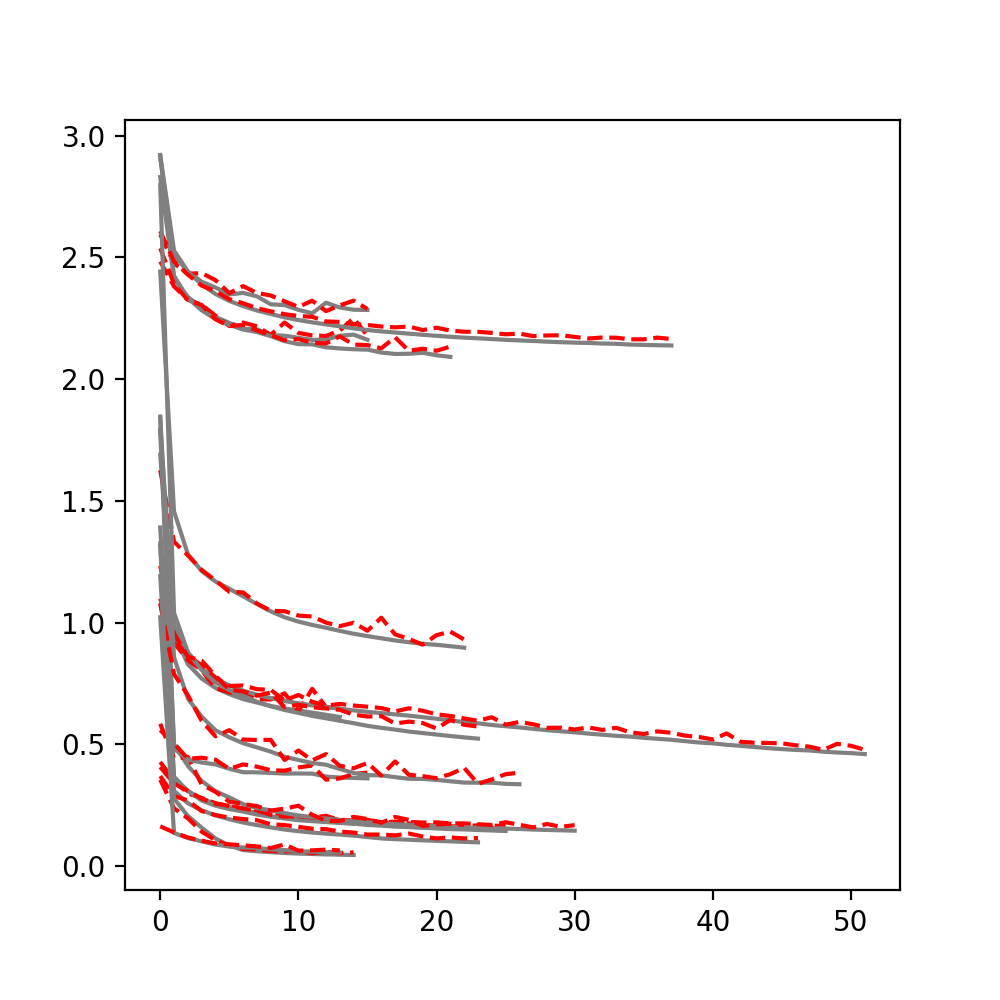

In [11]:
# look at some of the training and vlaidation trajectories
plt.figure(figsize=(5,5) )
for train_loss,val_loss in zip(train_losses[::5],val_losses[::5]):
    plt.plot(train_loss,color="gray")
    plt.plot(val_loss, "--",color="red")

In [7]:
depths = np.array([len(arr) for arr in shapes]) # get number of layers
mean_widths = np.array([sum(arr)/len(arr) for arr in shapes]) # get mean width
final_val_loss = np.array([val_traj[-1] for val_traj in val_losses]) # get los validation loss

In [13]:
def plot_quartiles(data, color="black", top_K=None,offset=0):
    if top_K == None:
        top_K = data.shape[0]
    mins, low_qs, meds, upp_qs, maxs = np.percentile(data[:top_K], [0,25,50,75,100],axis=1)
    low_diffs = low_qs - mins # from min to lower quartile
    upp_diffs = maxs - upp_qs # from upper quartile to max
    Ks = np.arange(top_K)
    # plot upper quartile
    plt.errorbar(Ks+offset, upp_qs, yerr=np.stack(( np.zeros(top_K), upp_diffs )), #yerr is (below error, above error)
                 fmt="none",ecolor=color,elinewidth=0.8)
    # plot median
    plt.plot(Ks+offset, meds, "_", color=color)
    # plot upper quartile
    plt.errorbar(Ks+offset, low_qs, yerr=np.stack(( low_diffs, np.zeros(top_K) )), #yerr is (below error, above error)
                 fmt="none",ecolor=color,elinewidth=0.8)

In [14]:
bottle_neck_losses = final_val_loss.reshape((4,-1))

<IPython.core.display.Javascript object>


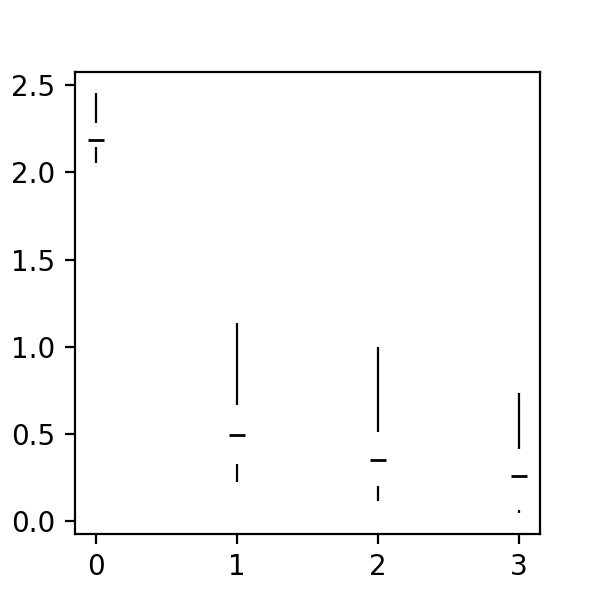

In [15]:
plt.figure(figsize=(3,3))
plot_quartiles(bottle_neck_losses)

<IPython.core.display.Javascript object>


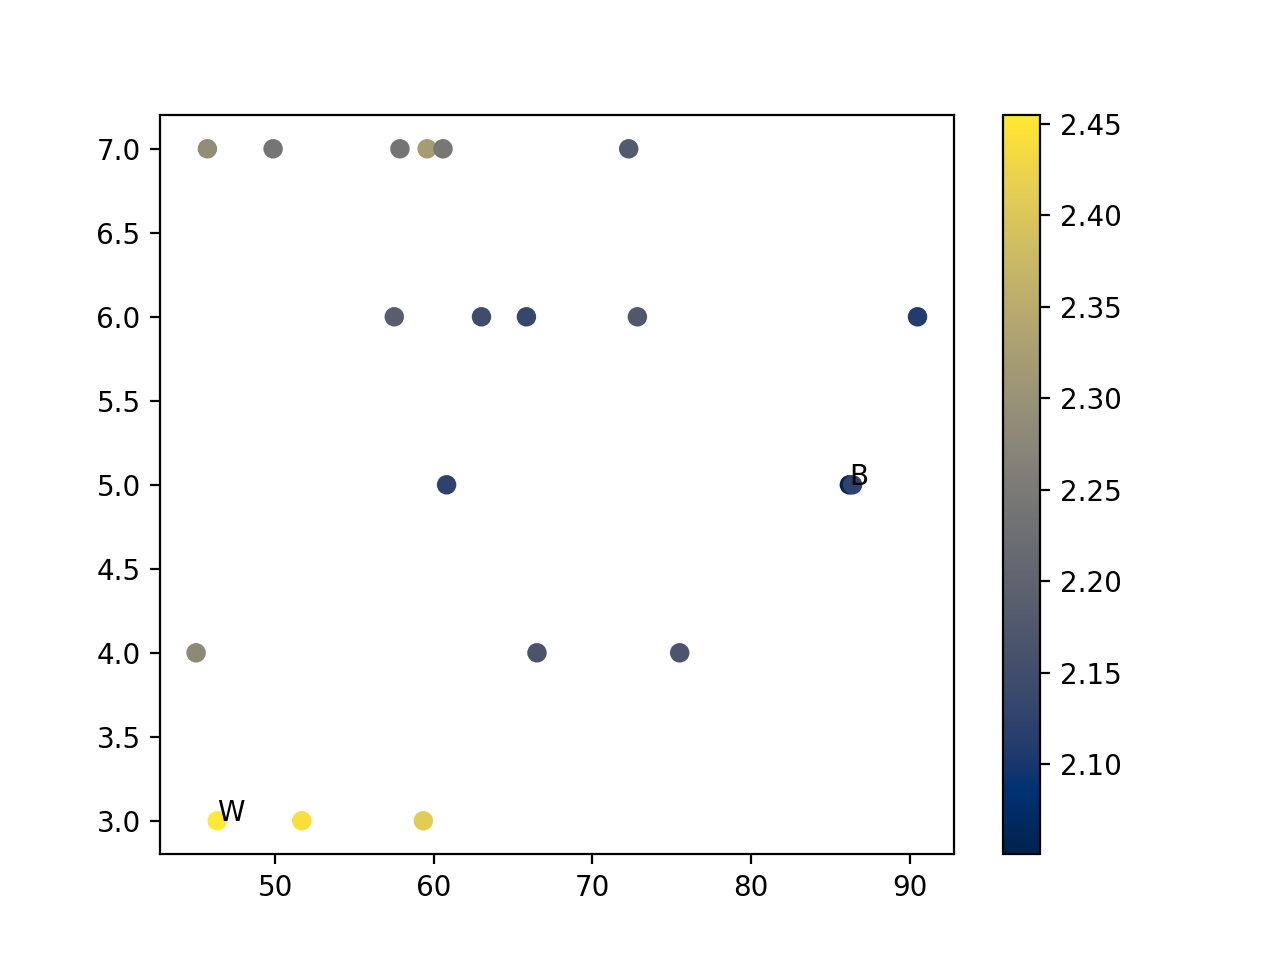

Best [100, 125, 113, 91, 2]
Worst [100, 37, 2]


<IPython.core.display.Javascript object>


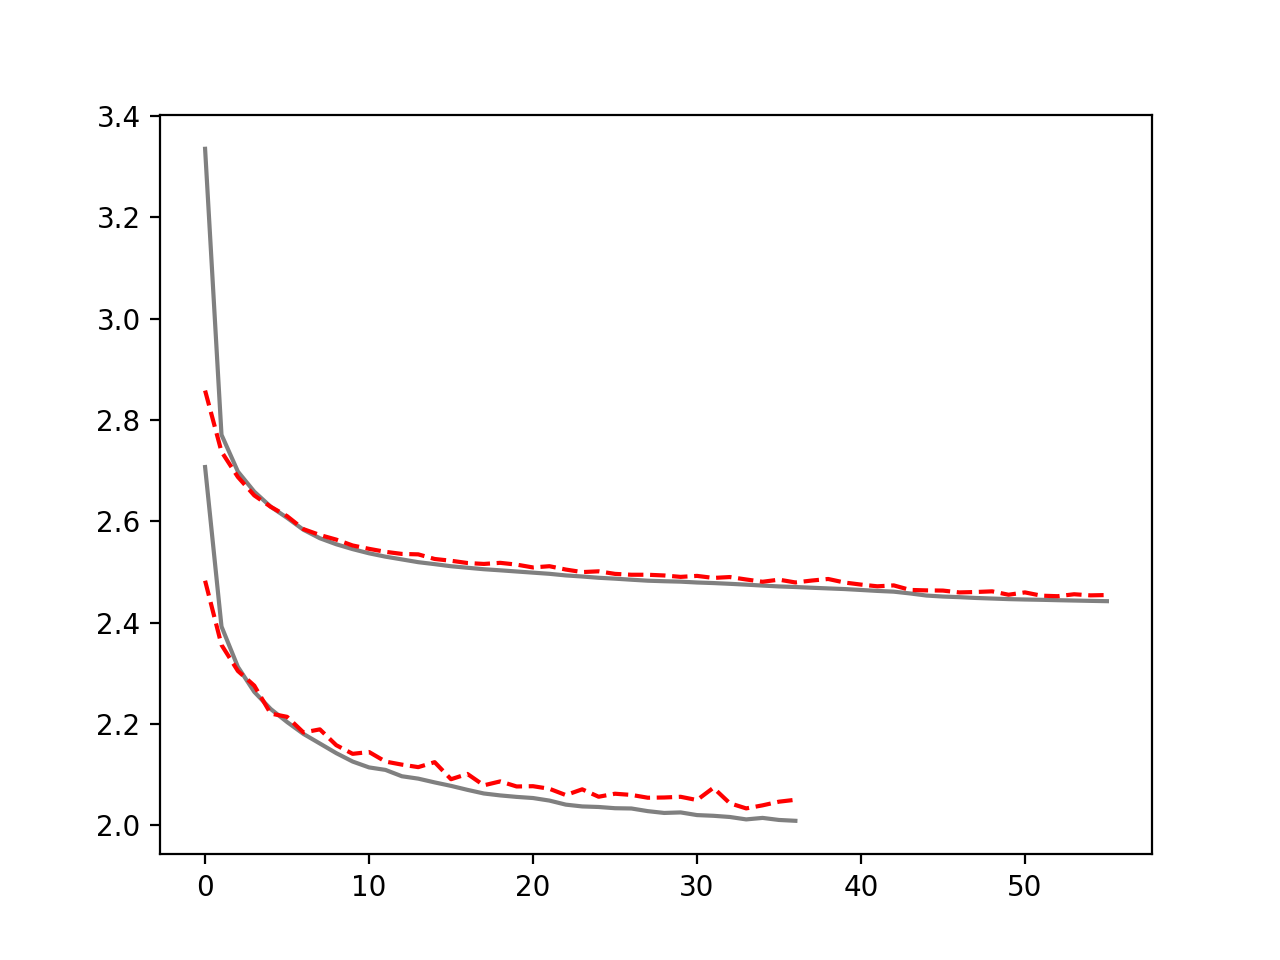

<IPython.core.display.Javascript object>


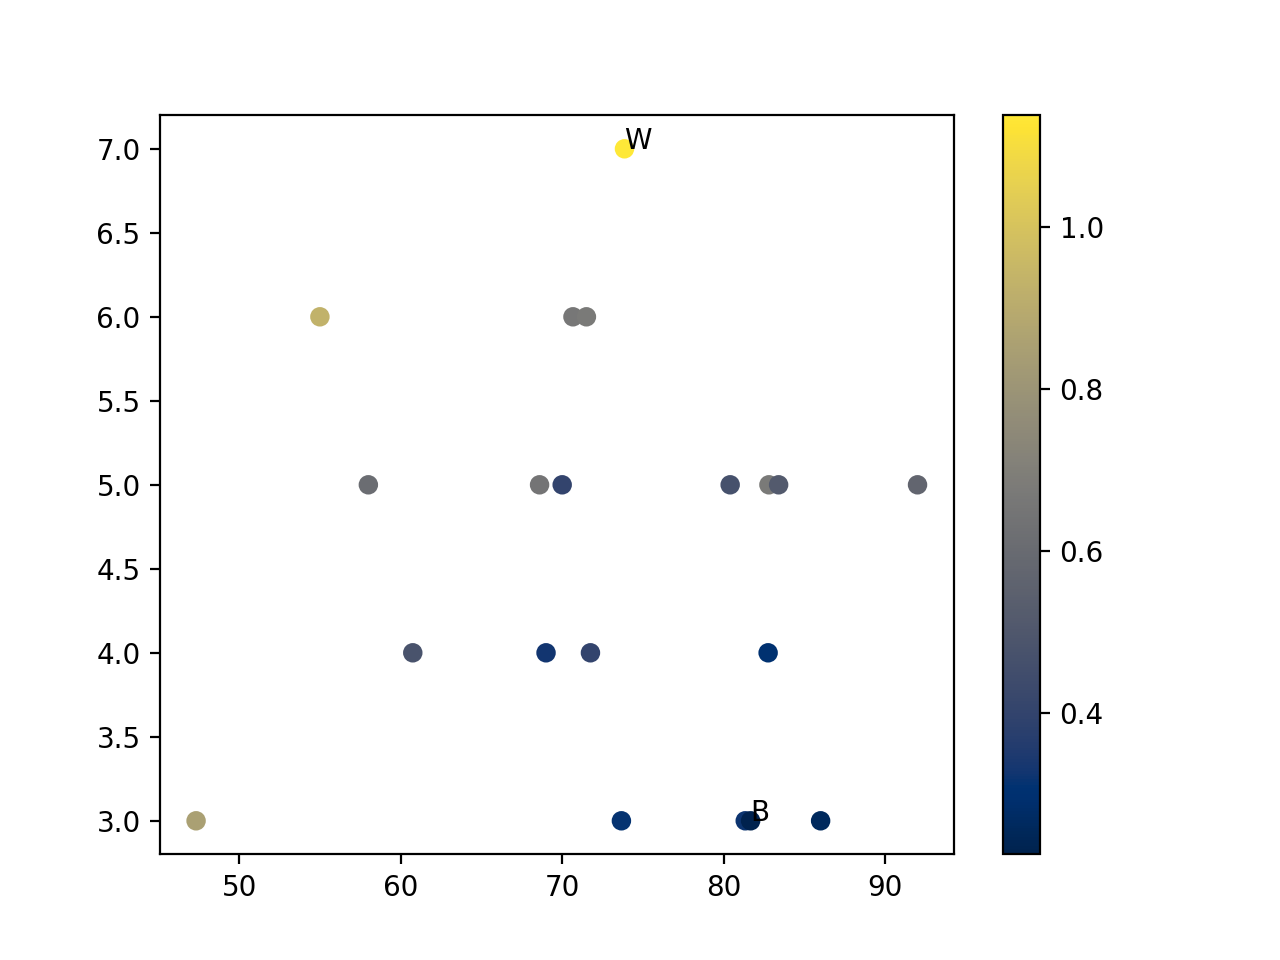

Best [100, 127, 18]
Worst [100, 124, 104, 69, 60, 42, 18]


<IPython.core.display.Javascript object>


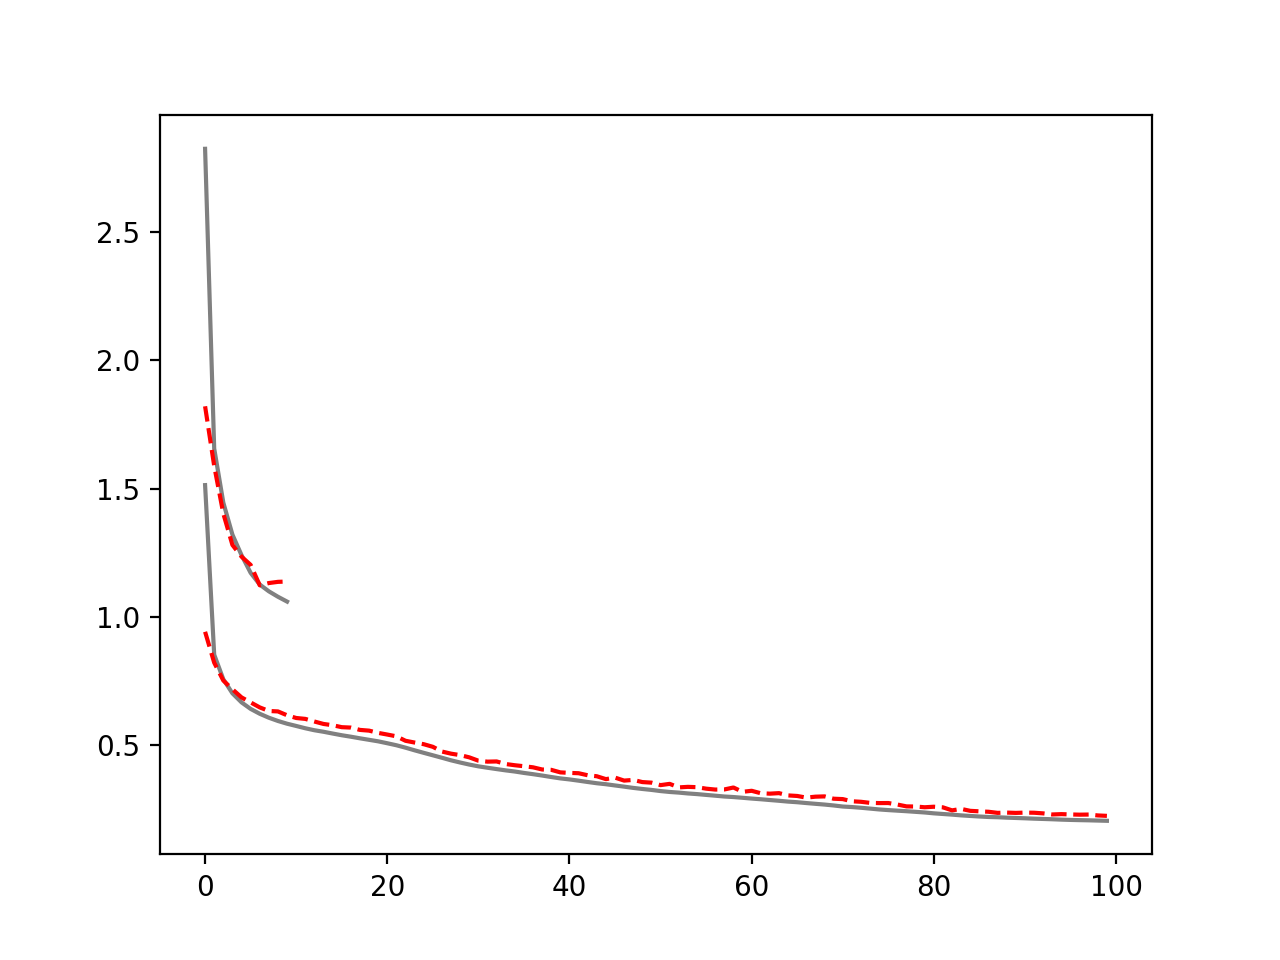

<IPython.core.display.Javascript object>


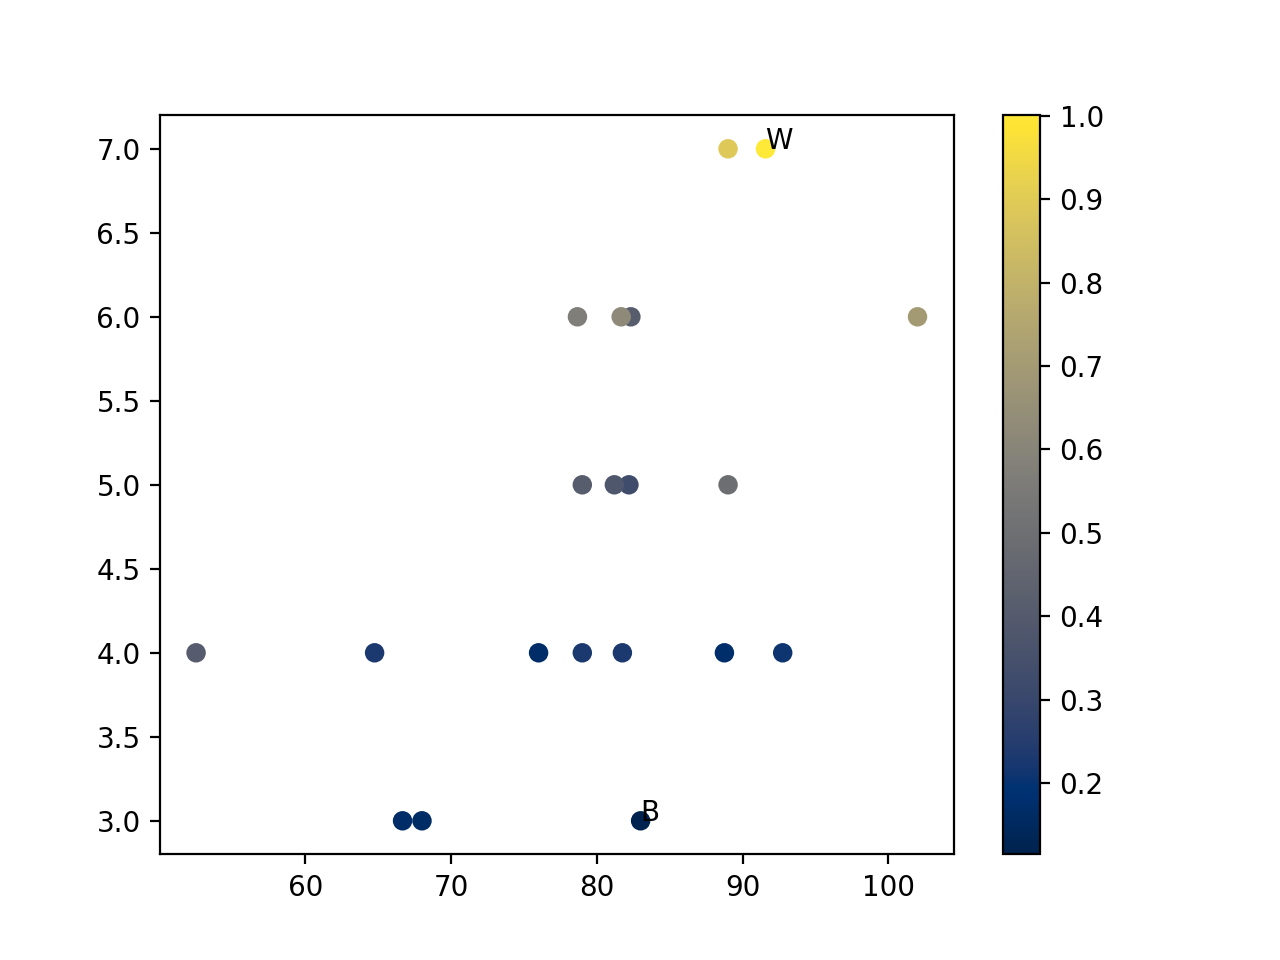

Best [100, 115, 34]
Worst [100, 141, 130, 118, 62, 56, 34]


<IPython.core.display.Javascript object>


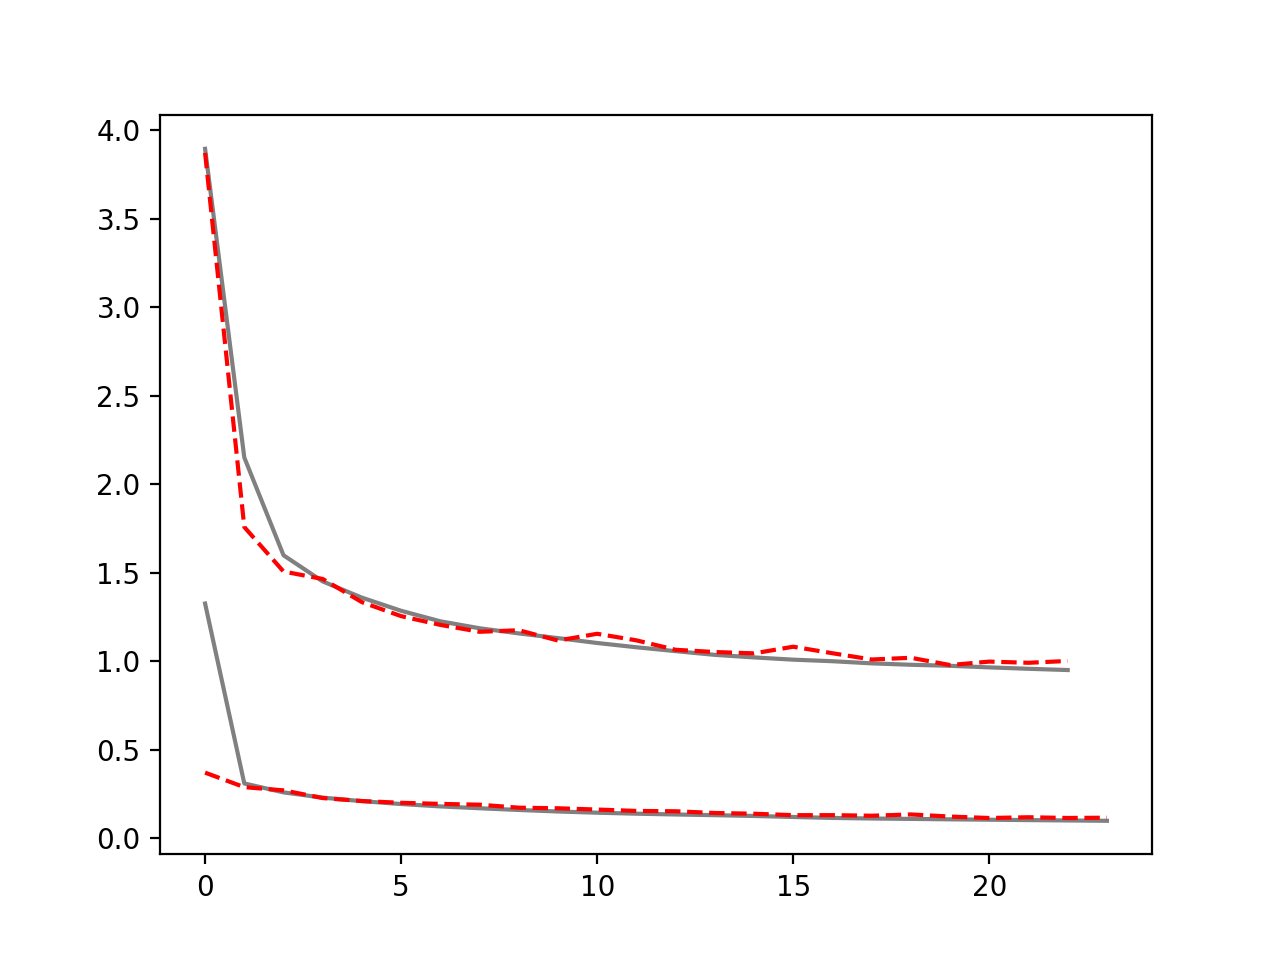

<IPython.core.display.Javascript object>


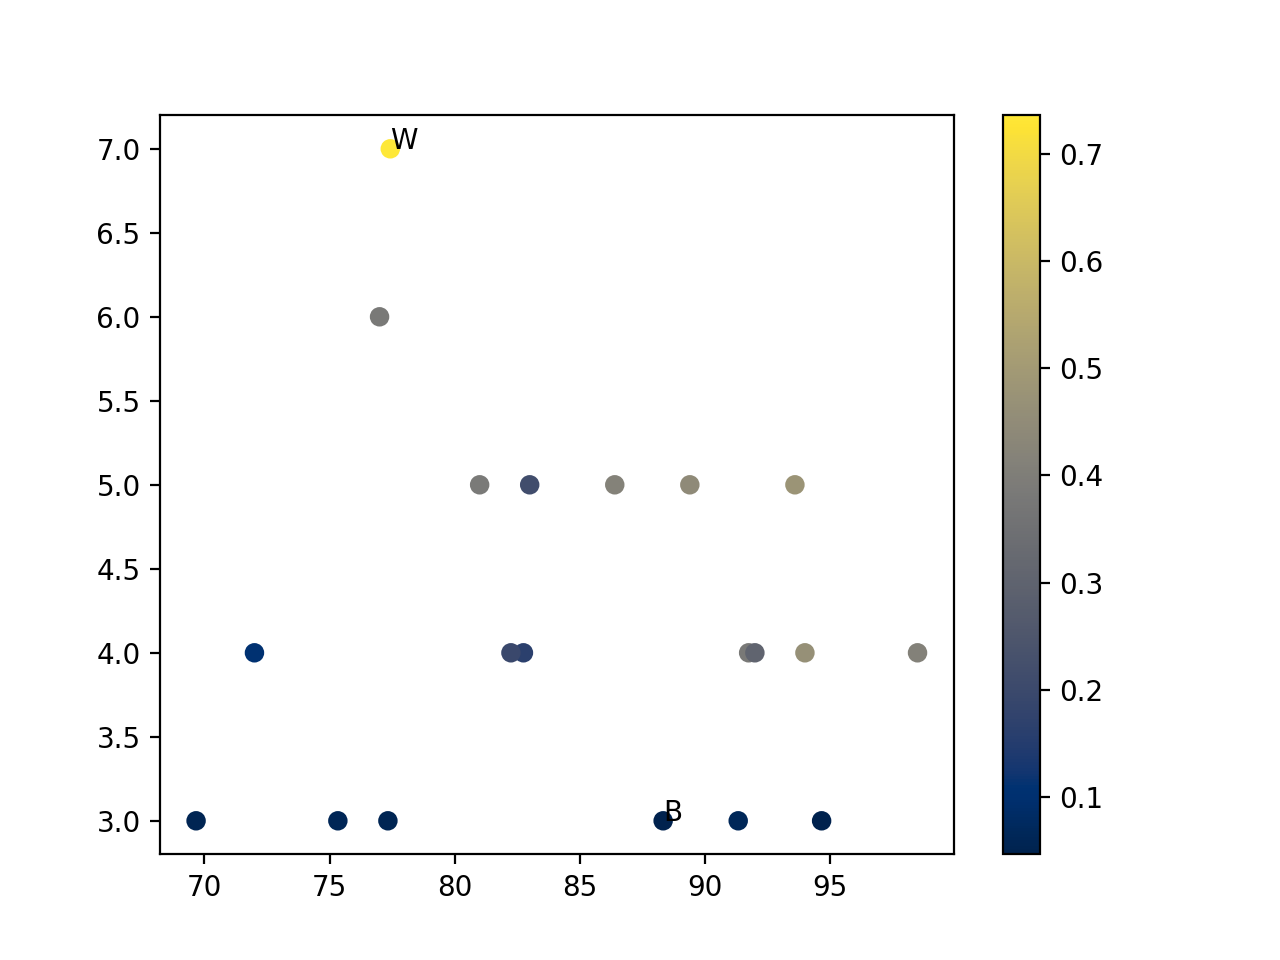

Best [100, 115, 50]
Worst [100, 115, 83, 72, 66, 56, 50]


<IPython.core.display.Javascript object>


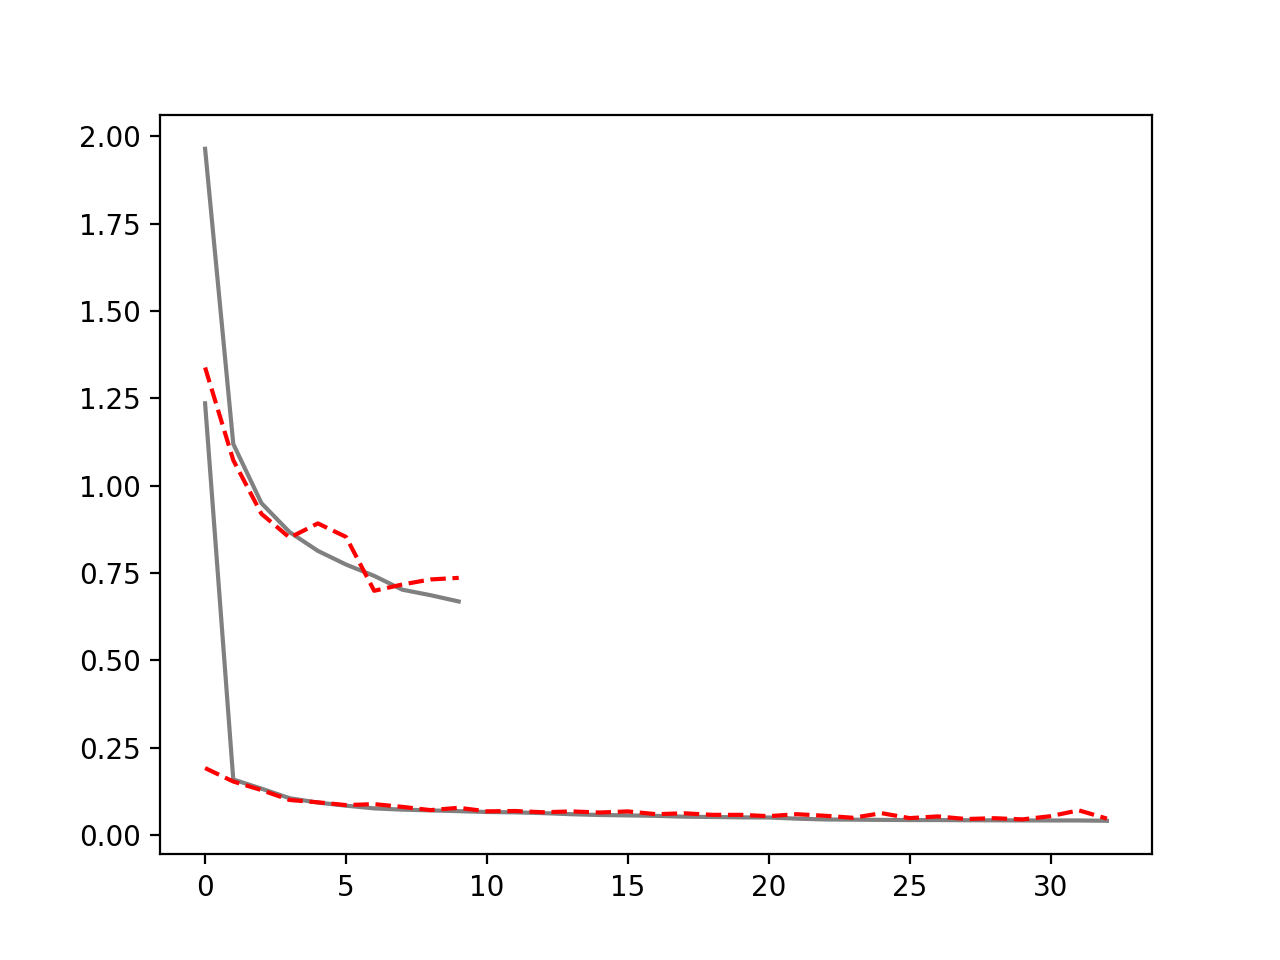

In [10]:
for b in range(4):
    plt.figure()
    cmap = plt.get_cmap("cividis")
    temp_widths = mean_widths[b*iterations:(b+1)*iterations]
    temp_depths = depths[b*iterations:(b+1)*iterations]
    temp_losses = final_val_loss[b*iterations:(b+1)*iterations]
    plt.scatter(temp_widths,temp_depths, c=temp_losses, cmap=cmap)
    plt.colorbar()
    # get index of best and worse architecture
    best_ind = np.argmin(temp_losses)
    worst_ind = np.argmax(temp_losses)
    print("Best", str(shapes[b*iterations:(b+1)*iterations][best_ind]) )
    print("Worst", str(shapes[b*iterations:(b+1)*iterations][worst_ind]))
          
    plt.annotate("B", (temp_widths[best_ind], temp_depths[best_ind]) )
    plt.annotate("W", (temp_widths[worst_ind], temp_depths[worst_ind]) )
    plt.show()
    
    plt.figure()
        # look at some of the training and vlaidation trajectories
    plt.plot(train_losses[b*iterations:(b+1)*iterations][best_ind],color="gray")
    plt.plot(val_losses[b*iterations:(b+1)*iterations][best_ind], "--",color="red")
    plt.plot(train_losses[b*iterations:(b+1)*iterations][worst_ind],color="gray")
    plt.plot(val_losses[b*iterations:(b+1)*iterations][worst_ind], "--",color="red")
    plt.show